# STROKE DETECTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
import time as timer
from sklearn.inspection import permutation_importance

In [2]:
# Load dataset
filename = "train_2v.csv"
data = pd.read_csv(filename)

In [3]:
# Display first few rows and shape of the dataset
with pd.option_context('expand_frame_repr', False):
    display(data.head())
print("Data shape: {}".format(data.shape))

id  gender   age  hypertension  heart_disease ever_married     work_type Residence_type  avg_glucose_level   bmi   smoking_status  stroke
0  30669    Male   3.0             0              0           No      children          Rural              95.12  18.0              NaN       0
1  30468    Male  58.0             1              0          Yes       Private          Urban              87.96  39.2     never smoked       0
2  16523  Female   8.0             0              0           No       Private          Urban             110.89  17.6              NaN       0
3  56543  Female  70.0             0              0          Yes       Private          Rural              69.04  35.9  formerly smoked       0
4  46136    Male  14.0             0              0           No  Never_worked          Rural             161.28  19.1              NaN       0

Data shape: (43660, 12)


In [4]:
# Display summary statistics
display(data.describe())

id           age  ...           bmi        stroke
count  43660.000000  43660.000000  ...  42158.000000  43660.000000
mean   36329.762689     42.364474  ...     28.615046      0.023637
std    21076.000408     22.559083  ...      7.766322      0.151918
min        1.000000      0.080000  ...     10.100000      0.000000
25%    18030.500000     24.000000  ...     23.300000      0.000000
50%    36350.500000     44.000000  ...     27.800000      0.000000
75%    54524.250000     60.000000  ...     32.900000      0.000000
max    72943.000000     82.000000  ...     97.600000      1.000000

[8 rows x 7 columns]

In [5]:
# Calculate and display missing values percentage
miss_val = data.isnull().sum() / len(data) * 100
display(miss_val)
print("# Missing values in variable 'bmi': {:.2f}%".format(miss_val['bmi']))
print("# Missing values in variable 'smoking_status': {:.2f}%".format(miss_val['smoking_status']))

id                    0.000000
gender                0.000000
age                   0.000000
hypertension          0.000000
heart_disease         0.000000
ever_married          0.000000
work_type             0.000000
Residence_type        0.000000
avg_glucose_level     0.000000
bmi                   3.440220
smoking_status       30.444343
stroke                0.000000
dtype: float64

# Missing values in variable 'bmi': 3.44%
# Missing values in variable 'smoking_status': 30.44%


In [6]:
# Handle missing values
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())
clean_data = data.dropna(subset=['smoking_status'])

In [7]:
# Drop the 'id' column
clean_data = clean_data.drop(columns='id')

In [8]:
# Validate there are no more missing values
miss_val_clean = clean_data.isnull().sum() / len(clean_data) * 100
display(miss_val_clean)
print("# Missing values in variable 'bmi': {}".format(miss_val_clean['bmi']))
print("# Missing values in variable 'smoking_status': {}".format(miss_val_clean['smoking_status']))
print("Shape of data without missing values: {}".format(clean_data.shape))

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64

# Missing values in variable 'bmi': 0.0
# Missing values in variable 'smoking_status': 0.0
Shape of data without missing values: (30368, 11)


In [9]:
print("Unique 'gender': {}".format(clean_data['gender'].unique()))
print("Unique 'ever_married': {}".format(clean_data['ever_married'].unique()))
print("Unique 'work_type': {}".format(clean_data['work_type'].unique()))
print("Unique 'Residence_type': {}".format(clean_data['Residence_type'].unique()))
print("Unique 'smoking_status': {}".format(clean_data['smoking_status'].unique()))

Unique 'gender': ['Male' 'Female' 'Other']
Unique 'ever_married': ['Yes' 'No']
Unique 'work_type': ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Unique 'Residence_type': ['Urban' 'Rural']
Unique 'smoking_status': ['never smoked' 'formerly smoked' 'smokes' 'Unknown']


In [10]:
# create encoder for each categorical variable
label_gender = LabelEncoder()
label_married = LabelEncoder()
label_work = LabelEncoder()
label_residence = LabelEncoder()
label_smoking = LabelEncoder()

In [11]:
clean_data['gender'] = label_gender.fit_transform(clean_data['gender'])
clean_data['ever_married'] = label_married.fit_transform(clean_data['ever_married'])
clean_data['work_type']= label_work.fit_transform(clean_data['work_type'])
clean_data['Residence_type']= label_residence.fit_transform(clean_data['Residence_type'])
clean_data['smoking_status']= label_smoking.fit_transform(clean_data['smoking_status'])
with pd.option_context('expand_frame_repr', False):
    print(clean_data.head())
    

   gender   age  hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level   bmi  smoking_status  stroke
1       1  58.0             1              0             1          2               1              87.96  39.2               2       0
3       0  70.0             0              0             1          2               0              69.04  35.9               1       0
6       0  52.0             0              0             1          2               1              77.59  17.7               1       0
7       0  75.0             0              1             1          3               0             243.53  27.0               2       0
8       0  32.0             0              0             1          2               0              77.67  32.3               3       0


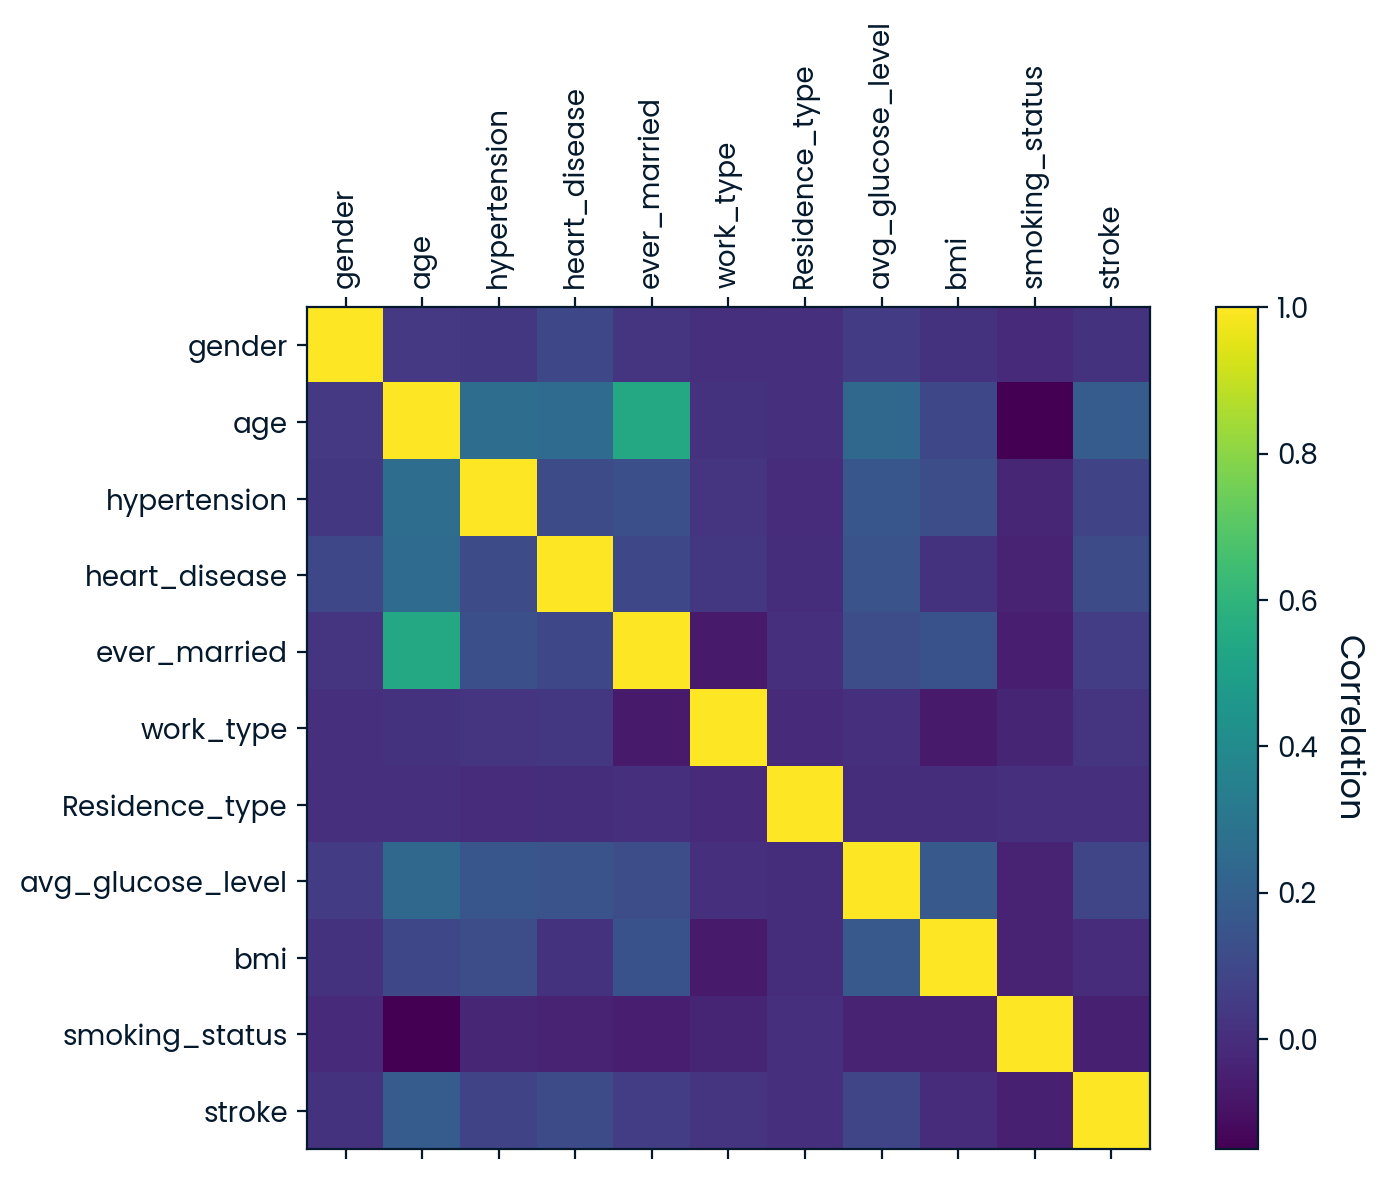

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.matshow(clean_data.corr())
ax.set_xticks(np.arange(clean_data.shape[1]))
ax.set_yticks(np.arange(clean_data.shape[1]))
ax.set_xticklabels(clean_data.columns,rotation=90)
ax.set_yticklabels(clean_data.columns)
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontsize=12)
fig.tight_layout()
plt.show()

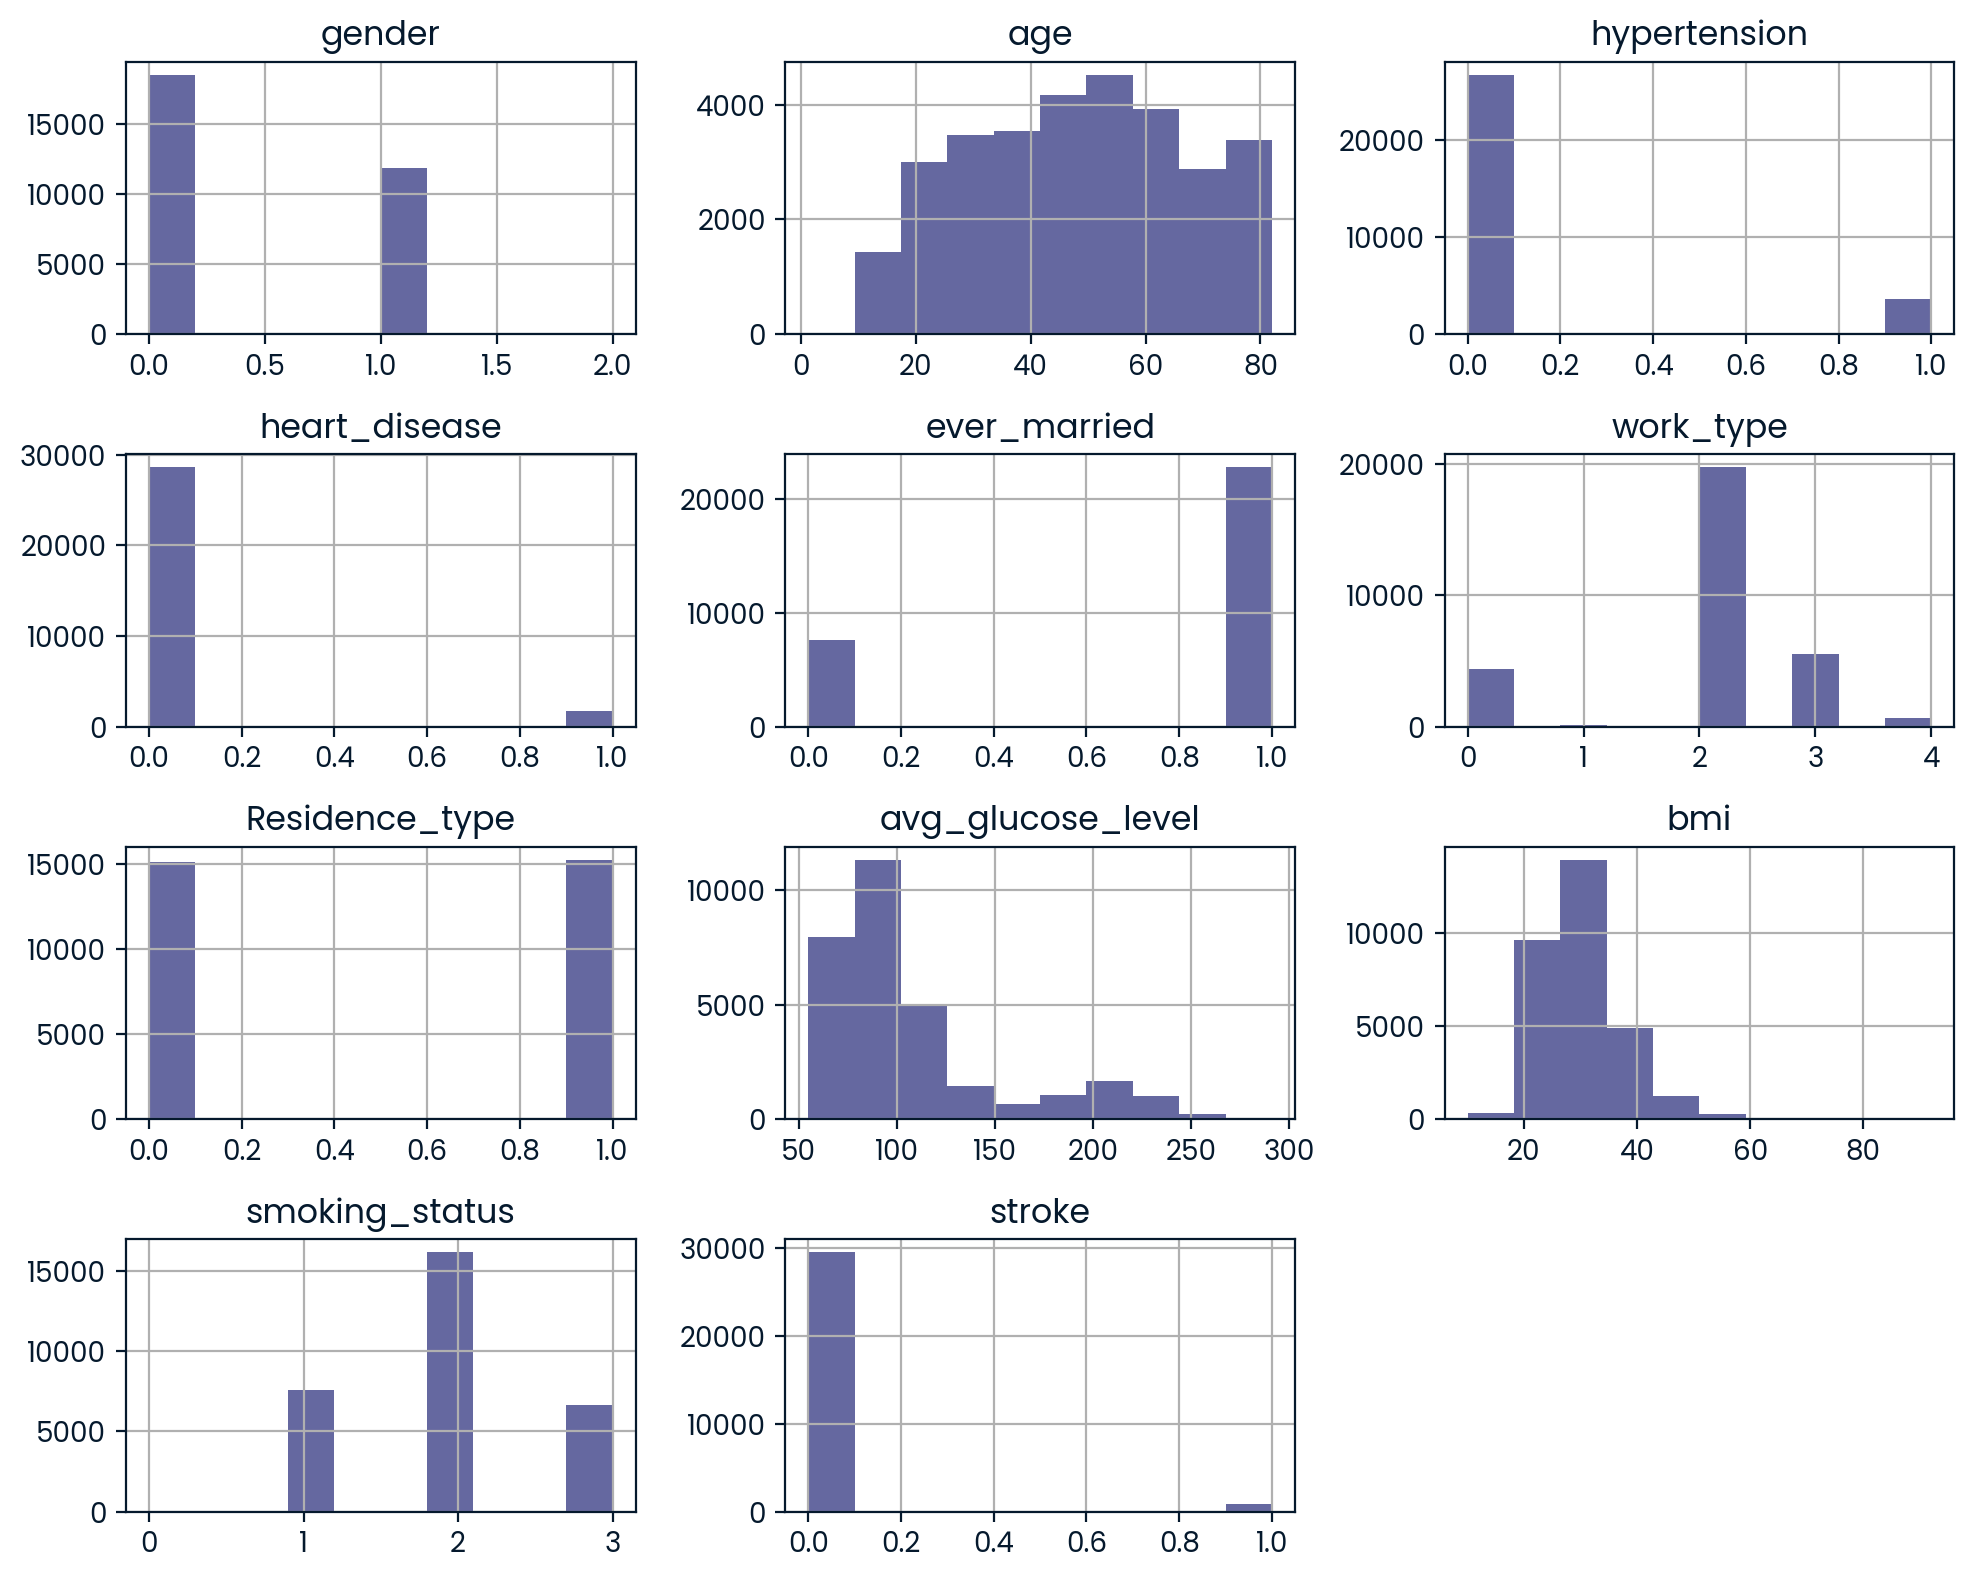

In [13]:
fig = clean_data.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

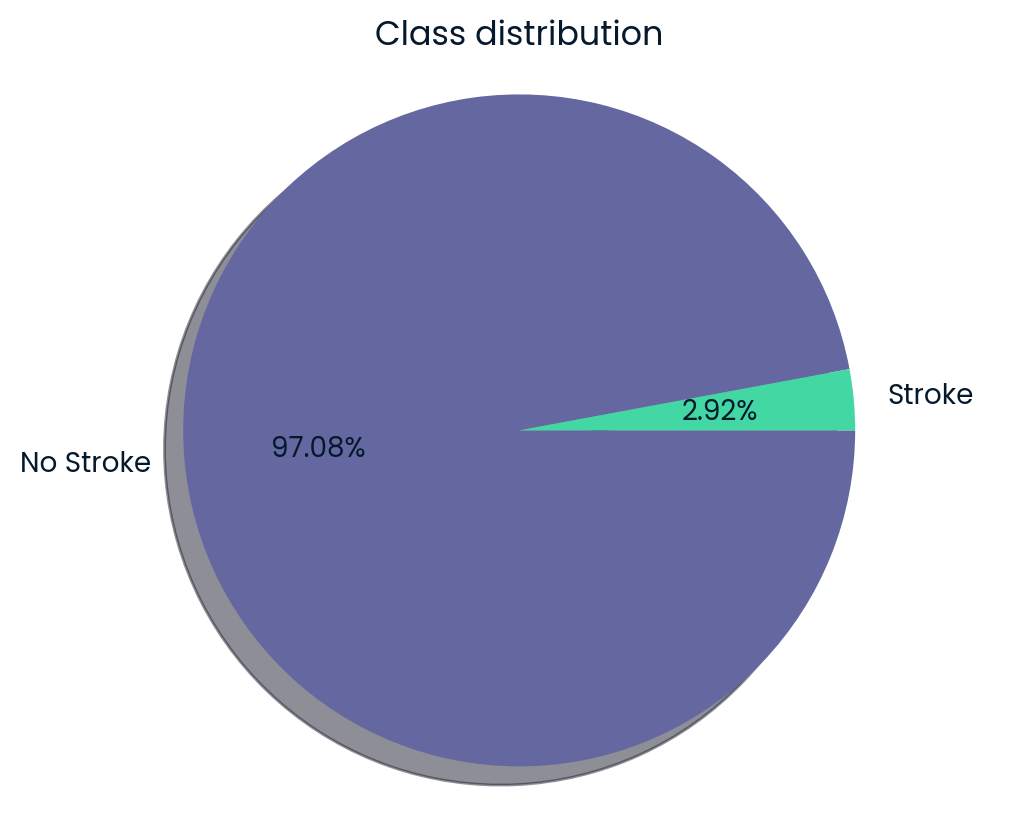

# samples associated with no stroke: 29481
# samples associated with stroke: 887


In [14]:
class_occur = clean_data['stroke'].value_counts()
class_names = ['No Stroke','Stroke']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_occur[0]))
print("# samples associated with stroke: {}".format(class_occur[1]))

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

# Sample data for demonstration purposes
X = np.random.rand(887, 10)  # 887 samples, 10 features
y = np.random.randint(0, 2, 887)  # 887 samples, binary target

def split_train_valid_test(X, y, test_size=0.1, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size/(1-test_size), random_state=random_state, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X, y, test_size=0.1, random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0], train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0], valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0], test_counts[1]))

[train] # class 0: 352 | # class 1: 357
[valid] # class 0: 44 | # class 1: 45
[test]  # class 0: 44 | # class 1: 45


In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns in 'data' dataframe
label_encoders = {}
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define features and target
X = data.drop(columns=['id', 'stroke'])
y = data['stroke']

# Split the data into training, validation, and test sets
X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X, y, test_size=0.1, random_state=42)

# Display the shapes of the resulting datasets
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((34928, 10), (4366, 10), (4366, 10), (34928,), (4366,), (4366,))

In [17]:
def calc_sens_spec(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    # calculate the sensitivity
    sensitivity = TP / (TP + FN)
    # calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from time import time

# Assuming X_train, X_test, y_train, y_test are already defined
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

start = timer.time()
svm_model = SVC(kernel='rbf',probability=True)
svm_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))

# Predicting the test set results
y_svm = svm_model.predict(X_test_std)
y_svm_prob = svm_model.predict_proba(X_test_std)

Finished training within 48.63 seconds


Classification report for SVM: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4263
           1       0.00      0.00      0.00       103

    accuracy                           0.98      4366
   macro avg       0.49      0.50      0.49      4366
weighted avg       0.95      0.98      0.96      4366

Confusion matrix for SVM: 
[[4263    0]
 [ 103    0]]
Accuracy score for SVM: 0.98
Precision score for SVM: 0.00
Recall score for SVM: 0.00
F1 score for SVM: 0.00
Sensitivity score for SVM: 0.00
Specitivity score for SVM: 1.00
AUC score for SVM: 0.73


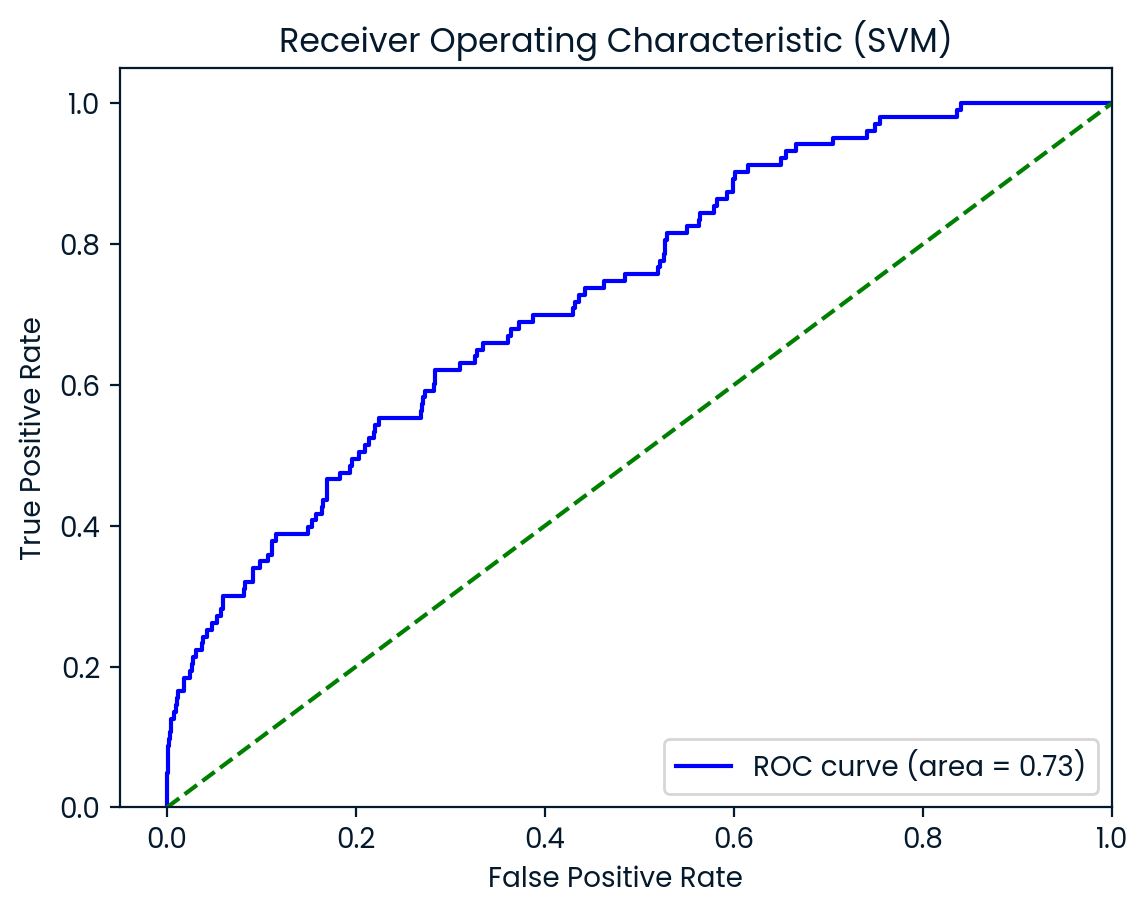

In [19]:
print("Classification report for SVM: \n{}".format(classification_report(y_test,y_svm)))
print("Confusion matrix for SVM: \n{}".format(confusion_matrix(y_test,y_svm)))
print("Accuracy score for SVM: {:.2f}".format(accuracy_score(y_test,y_svm)))

# calculate precision, recall, and f1 scores
prec_svm = precision_score(y_test,y_svm)
rec_svm = recall_score(y_test,y_svm)
f1_svm = f1_score(y_test,y_svm)
print("Precision score for SVM: {:.2f}".format(prec_svm))
print("Recall score for SVM: {:.2f}".format(rec_svm))
print("F1 score for SVM: {:.2f}".format(f1_svm))

# calculate sensitivity, specificity, and auc
sens_svm,spec_svm = calc_sens_spec(y_test,y_svm)
fpr, tpr, _ = roc_curve(y_test,  y_svm_prob[:,1])
auc_svm = roc_auc_score(y_test, y_svm_prob[:,1])
print("Sensitivity score for SVM: {:.2f}".format(sens_svm))
print("Specitivity score for SVM: {:.2f}".format(spec_svm))
print("AUC score for SVM: {:.2f}".format(auc_svm))

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc="lower right")
plt.show()

In [20]:
start = timer.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_gnb = gnb_model.predict(X_test_std)
y_gnb_prob = gnb_model.predict_proba(X_test_std)

Finished training within 0.01 seconds


Classification report for GNB: 
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4263
           1       0.08      0.34      0.13       103

    accuracy                           0.89      4366
   macro avg       0.53      0.62      0.54      4366
weighted avg       0.96      0.89      0.92      4366

Confusion matrix for GNB: 
[[3859  404]
 [  68   35]]
Accuracy score for GNB: 0.89
Precision score for GNB: 0.08
Recall score for GNB: 0.34
F1 score for GNB: 0.13
Sensitivity score for GNB: 0.34
Specitivity score for GNB: 0.91
AUC score for GNB: 0.82


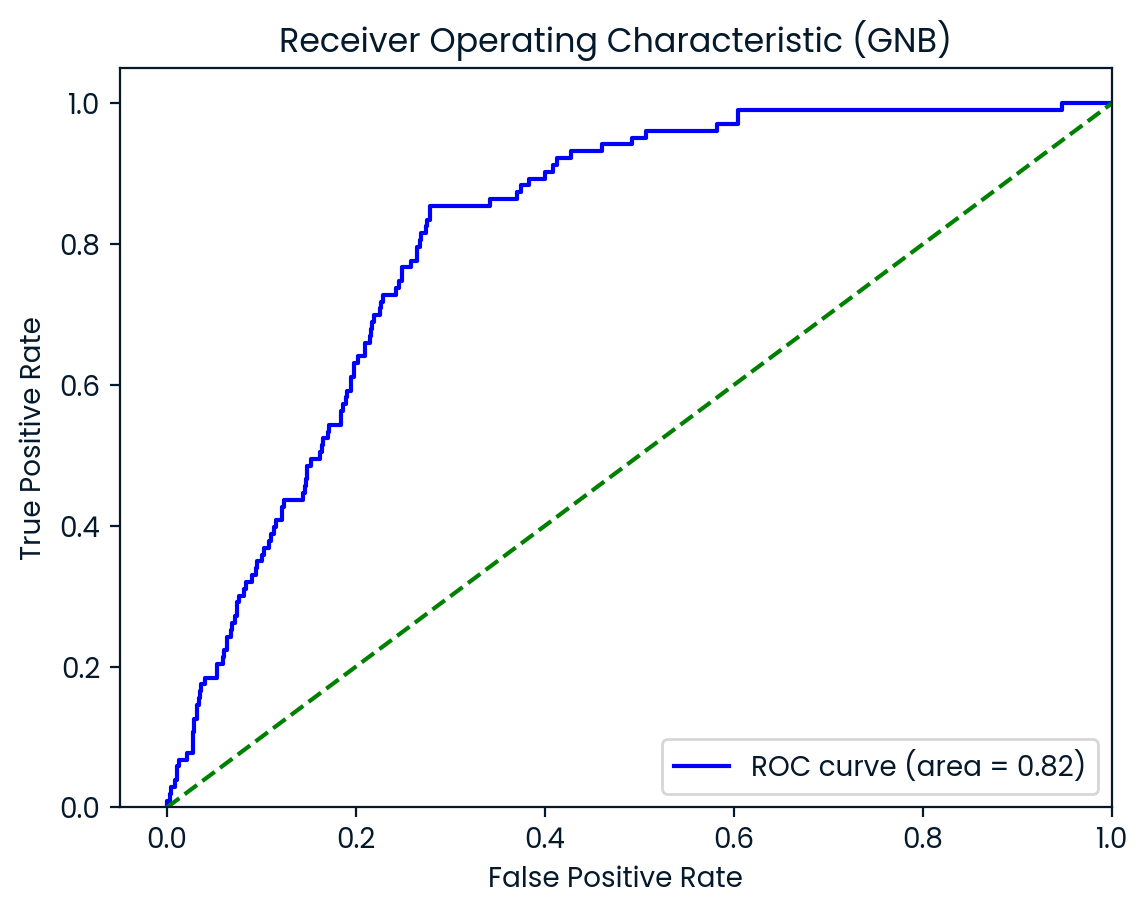

In [21]:
print("Classification report for GNB: \n{}".format(classification_report(y_test,y_gnb)))
print("Confusion matrix for GNB: \n{}".format(confusion_matrix(y_test,y_gnb)))
print("Accuracy score for GNB: {:.2f}".format(accuracy_score(y_test,y_gnb)))
# calculate precision, recall, and f1 scores
prec_gnb = precision_score(y_test,y_gnb)
rec_gnb = recall_score(y_test,y_gnb)
f1_gnb = f1_score(y_test,y_gnb)
print("Precision score for GNB: {:.2f}".format(prec_gnb))
print("Recall score for GNB: {:.2f}".format(rec_gnb))
print("F1 score for GNB: {:.2f}".format(f1_gnb))
# calculate sensitivity, specificity, and auc
sens_gnb,spec_gnb = calc_sens_spec(y_test,y_gnb)
fpr, tpr, _ = roc_curve(y_test,  y_gnb_prob[:,1])
auc_gnb = roc_auc_score(y_test, y_gnb_prob[:,1])
print("Sensitivity score for GNB: {:.2f}".format(sens_gnb))
print("Specitivity score for GNB: {:.2f}".format(spec_gnb))
print("AUC score for GNB: {:.2f}".format(auc_gnb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_gnb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (GNB)')
ax.legend(loc="lower right")
plt.show()

In [22]:
start = timer.time()
logit_model = LogisticRegression(solver='lbfgs', random_state=42)
logit_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_logit = logit_model.predict(X_test_std)
y_logit_prob = logit_model.predict_proba(X_test_std)

Finished training within 0.11 seconds


Classification report for LR: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4263
           1       0.00      0.00      0.00       103

    accuracy                           0.98      4366
   macro avg       0.49      0.50      0.49      4366
weighted avg       0.95      0.98      0.96      4366

Confusion matrix for LR: 
[[4263    0]
 [ 103    0]]
Accuracy score for LR: 0.98
Precision score for LR: 0.00
Recall score for LR: 0.00
F1 score for LR: 0.00
Sensitivity score for LR: 0.00
Specitivity score for LR: 1.00
AUC score for LR: 0.85


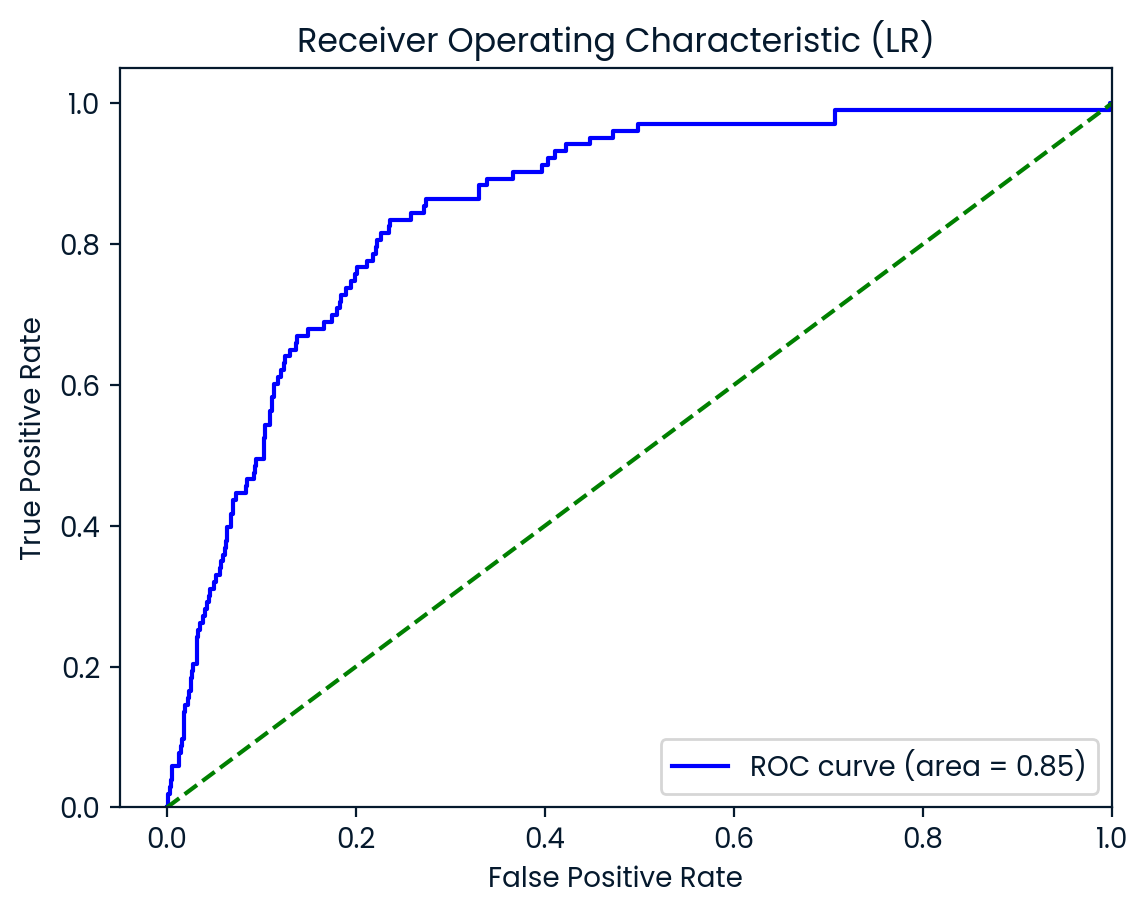

In [23]:
print("Classification report for LR: \n{}".format(classification_report(y_test,y_logit)))
print("Confusion matrix for LR: \n{}".format(confusion_matrix(y_test,y_logit)))
print("Accuracy score for LR: {:.2f}".format(accuracy_score(y_test,y_logit)))
# calculate precision, recall, and f1 scores
prec_logit = precision_score(y_test,y_logit)
rec_logit = recall_score(y_test,y_logit)
f1_logit = f1_score(y_test,y_logit)
print("Precision score for LR: {:.2f}".format(prec_logit))
print("Recall score for LR: {:.2f}".format(rec_logit))
print("F1 score for LR: {:.2f}".format(f1_logit))
# calculate sensitivity, specificity, and auc
sens_logit,spec_logit = calc_sens_spec(y_test,y_logit)
fpr, tpr, _ = roc_curve(y_test,  y_logit_prob[:,1])
auc_logit = roc_auc_score(y_test, y_logit_prob[:,1])
print("Sensitivity score for LR: {:.2f}".format(sens_logit))
print("Specitivity score for LR: {:.2f}".format(spec_logit))
print("AUC score for LR: {:.2f}".format(auc_logit))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_logit)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (LR)')
ax.legend(loc="lower right")
plt.show()

In [24]:
start = timer.time()
dtree_model = DecisionTreeClassifier(random_state=42)
dtree_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_dtree = dtree_model.predict(X_test_std)
y_dtree_prob = dtree_model.predict_proba(X_test_std)

Finished training within 0.12 seconds


Classification report for DT: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4263
           1       0.26      0.42      0.32       103

    accuracy                           0.96      4366
   macro avg       0.62      0.69      0.65      4366
weighted avg       0.97      0.96      0.96      4366

Confusion matrix for DT: 
[[4143  120]
 [  60   43]]
Accuracy score for DT: 0.96
Precision score for DT: 0.26
Recall score for DT: 0.42
F1 score for DT: 0.32
Sensitivity score for DT: 0.42
Specitivity score for DT: 0.97
AUC score for DT: 0.69


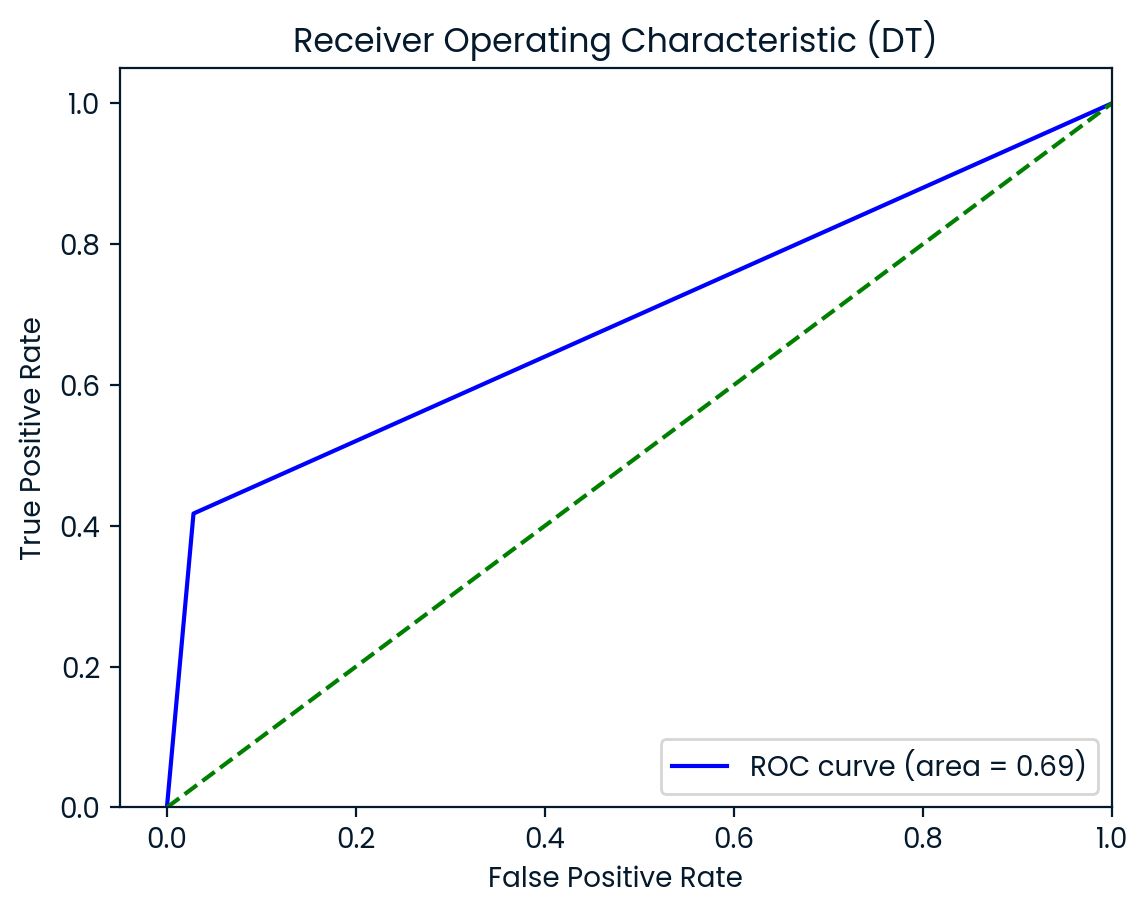

In [25]:
print("Classification report for DT: \n{}".format(classification_report(y_test,y_dtree)))
print("Confusion matrix for DT: \n{}".format(confusion_matrix(y_test,y_dtree)))
print("Accuracy score for DT: {:.2f}".format(accuracy_score(y_test,y_dtree)))
# calculate precision, recall, and f1 scores
prec_dtree = precision_score(y_test,y_dtree)
rec_dtree = recall_score(y_test,y_dtree)
f1_dtree = f1_score(y_test,y_dtree)
print("Precision score for DT: {:.2f}".format(prec_dtree))
print("Recall score for DT: {:.2f}".format(rec_dtree))
print("F1 score for DT: {:.2f}".format(f1_dtree))
# calculate sensitivity, specificity, and auc
sens_dtree,spec_dtree = calc_sens_spec(y_test,y_dtree)
fpr, tpr, _ = roc_curve(y_test,  y_dtree_prob[:,1])
auc_dtree = roc_auc_score(y_test, y_dtree_prob[:,1])
print("Sensitivity score for DT: {:.2f}".format(sens_dtree))
print("Specitivity score for DT: {:.2f}".format(spec_dtree))
print("AUC score for DT: {:.2f}".format(auc_dtree))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_dtree)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (DT)')
ax.legend(loc="lower right")
plt.show()

In [26]:
start = timer.time()
ranfor_model = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_ranfor = ranfor_model.predict(X_test_std)
y_ranfor_prob = ranfor_model.predict_proba(X_test_std)

Finished training within 3.20 seconds


Classification report for RF: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4263
           1       0.95      0.38      0.54       103

    accuracy                           0.98      4366
   macro avg       0.97      0.69      0.77      4366
weighted avg       0.98      0.98      0.98      4366

Confusion matrix for RF: 
[[4261    2]
 [  64   39]]
Accuracy score for RF: 0.98
Precision score for RF: 0.95
Recall score for RF: 0.38
F1 score for RF: 0.54
Sensitivity score for RF: 0.38
Specitivity score for RF: 1.00
AUC score for RF: 0.87


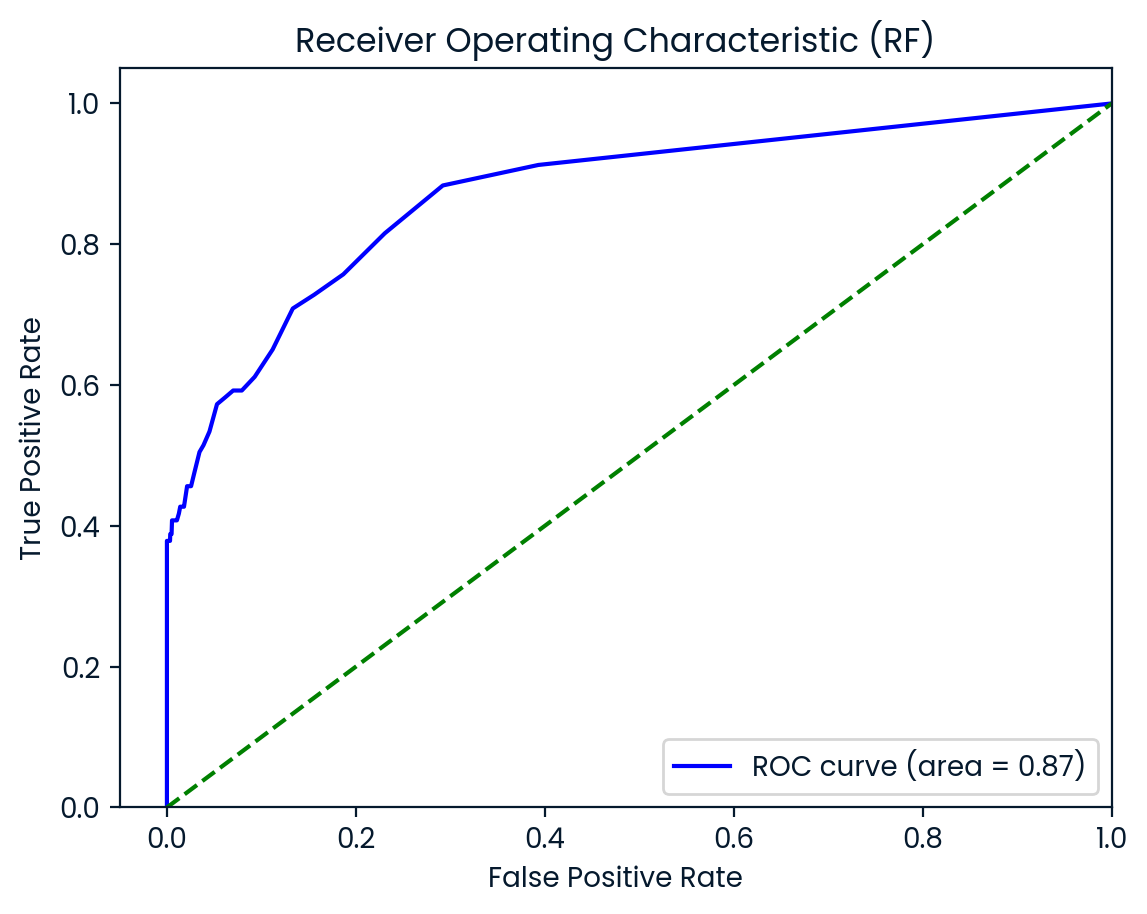

In [27]:
print("Classification report for RF: \n{}".format(classification_report(y_test,y_ranfor)))
print("Confusion matrix for RF: \n{}".format(confusion_matrix(y_test,y_ranfor)))
print("Accuracy score for RF: {:.2f}".format(accuracy_score(y_test,y_ranfor)))
# calculate precision, recall, and f1 scores
prec_ranfor = precision_score(y_test,y_ranfor)
rec_ranfor = recall_score(y_test,y_ranfor)
f1_ranfor = f1_score(y_test,y_ranfor)
print("Precision score for RF: {:.2f}".format(prec_ranfor))
print("Recall score for RF: {:.2f}".format(rec_ranfor))
print("F1 score for RF: {:.2f}".format(f1_ranfor))
# calculate sensitivity, specificity, and auc
sens_ranfor,spec_ranfor = calc_sens_spec(y_test,y_ranfor)
fpr, tpr, _ = roc_curve(y_test,  y_ranfor_prob[:,1])
auc_ranfor = roc_auc_score(y_test, y_ranfor_prob[:,1])
print("Sensitivity score for RF: {:.2f}".format(sens_ranfor))
print("Specitivity score for RF: {:.2f}".format(spec_ranfor))
print("AUC score for RF: {:.2f}".format(auc_ranfor))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_ranfor)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (RF)')
ax.legend(loc="lower right")
plt.show()

In [28]:
start = timer.time()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_xgb = xgb_model.predict(X_test_std)
y_xgb_prob = xgb_model.predict_proba(X_test_std)

Finished training within 0.26 seconds


Classification report for XGB: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4263
           1       0.80      0.12      0.20       103

    accuracy                           0.98      4366
   macro avg       0.89      0.56      0.60      4366
weighted avg       0.97      0.98      0.97      4366

Confusion matrix for XGB: 
[[4260    3]
 [  91   12]]
Accuracy score for XGB: 0.98
Precision score for XGB: 0.80
Recall score for XGB: 0.12
F1 score for XGB: 0.20
Sensitivity score for XGB: 0.12
Specitivity score for XGB: 1.00
AUC score for XGB: 0.89


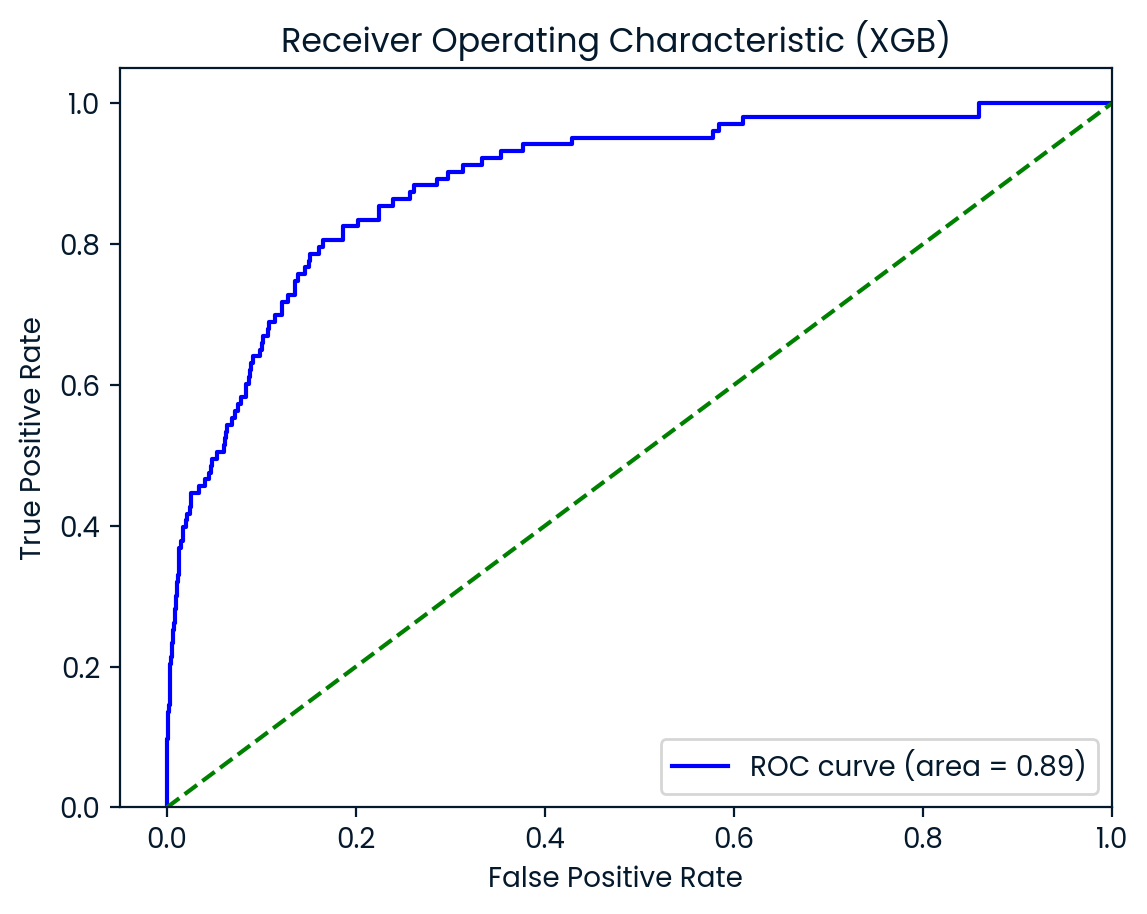

In [29]:
print("Classification report for XGB: \n{}".format(classification_report(y_test,y_xgb)))
print("Confusion matrix for XGB: \n{}".format(confusion_matrix(y_test,y_xgb)))
print("Accuracy score for XGB: {:.2f}".format(accuracy_score(y_test,y_xgb)))
# calculate precision, recall, and f1 scores
prec_xgb = precision_score(y_test,y_xgb)
rec_xgb = recall_score(y_test,y_xgb)
f1_xgb = f1_score(y_test,y_xgb)
print("Precision score for XGB: {:.2f}".format(prec_xgb))
print("Recall score for XGB: {:.2f}".format(rec_xgb))
print("F1 score for XGB: {:.2f}".format(f1_xgb))
# calculate sensitivity, specificity, and auc
sens_xgb,spec_xgb = calc_sens_spec(y_test,y_xgb)
fpr, tpr, _ = roc_curve(y_test,  y_xgb_prob[:,1])
auc_xgb = roc_auc_score(y_test, y_xgb_prob[:,1])
print("Sensitivity score for XGB: {:.2f}".format(sens_xgb))
print("Specitivity score for XGB: {:.2f}".format(spec_xgb))
print("AUC score for XGB: {:.2f}".format(auc_xgb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_xgb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (XGB)')
ax.legend(loc="lower right")
plt.show()

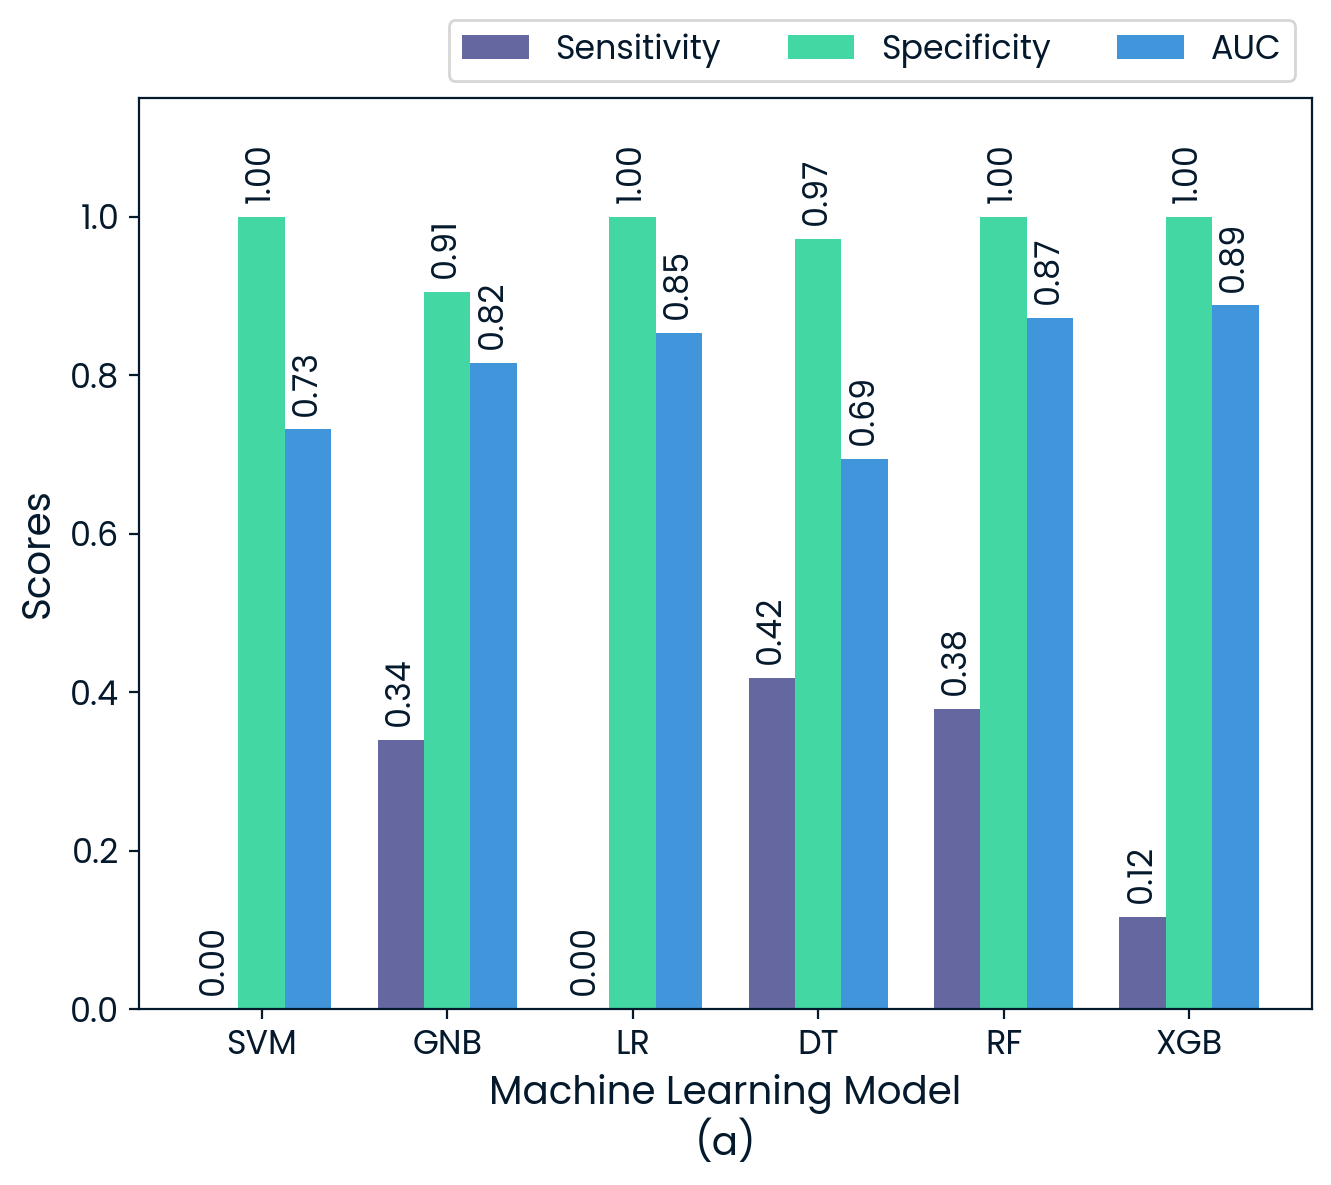

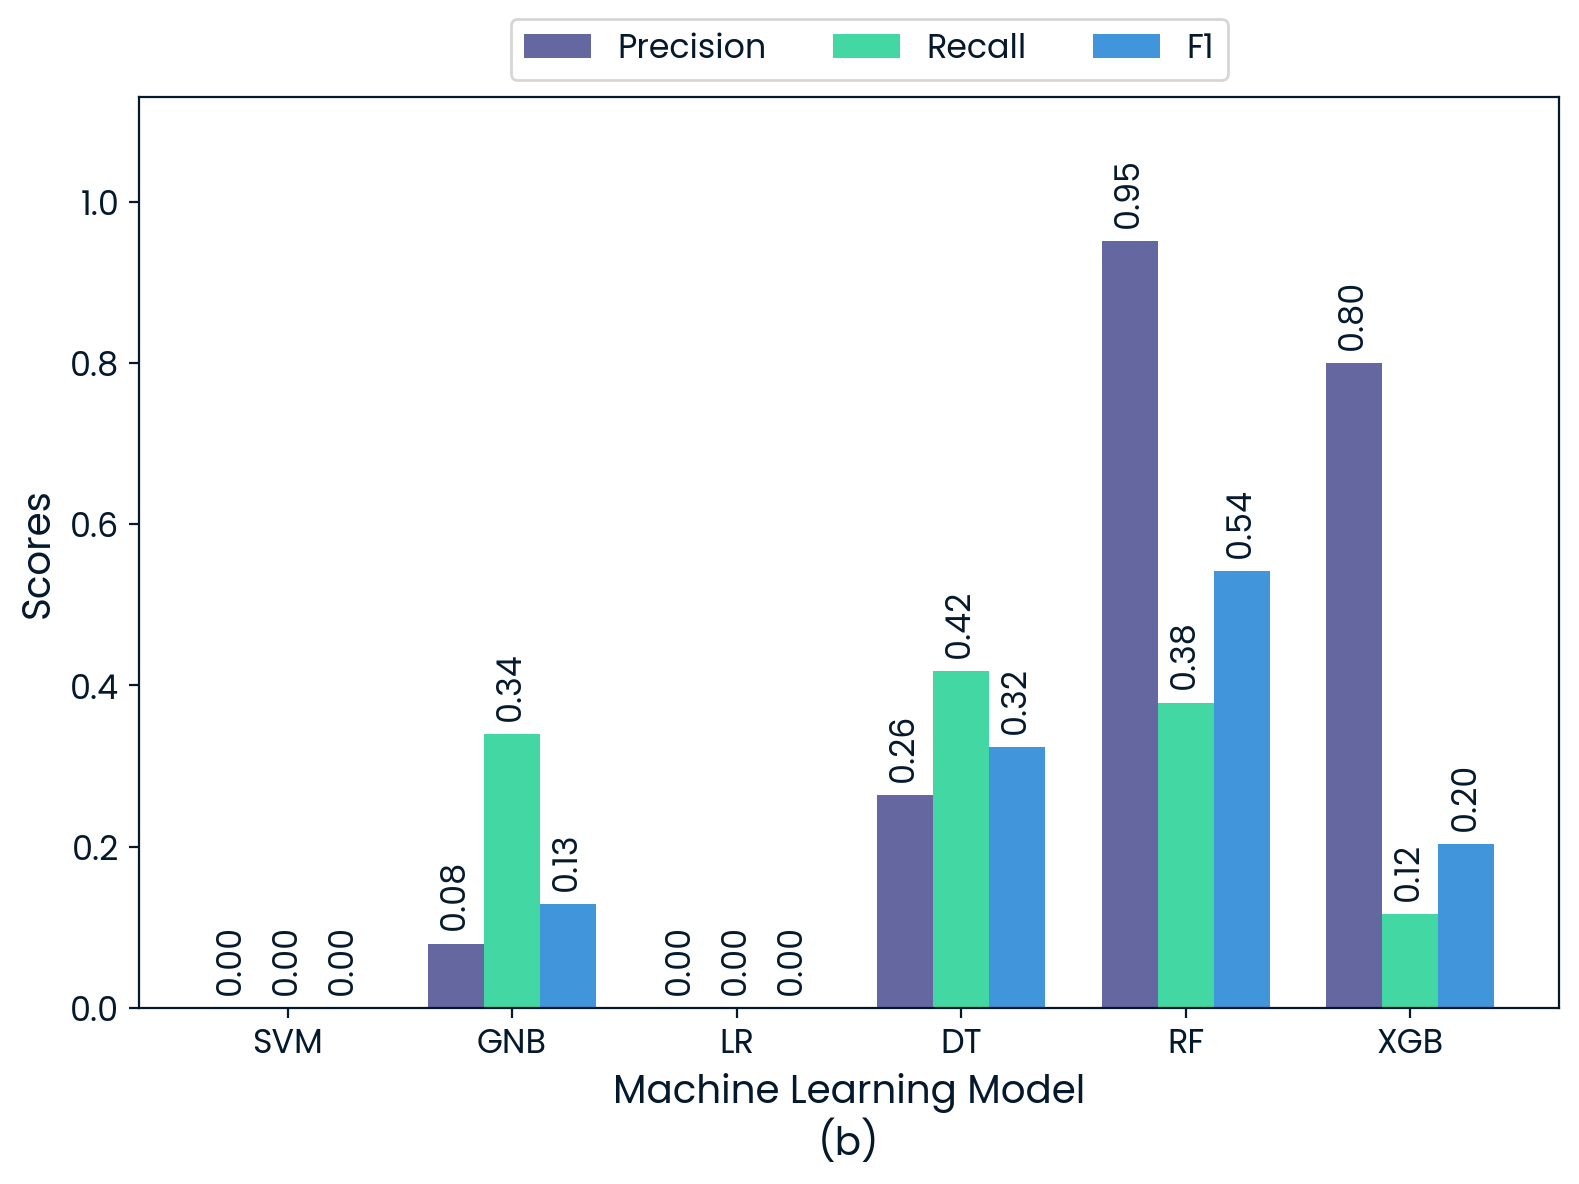

In [30]:
ml_names = ['SVM', 'GNB', 'LR', 'DT', 'RF', 'XGB']
sens_all = [sens_svm, sens_gnb, sens_logit, sens_dtree, sens_ranfor, sens_xgb]
spec_all = [spec_svm, spec_gnb, spec_logit, spec_dtree, spec_ranfor, spec_xgb]
auc_all = [auc_svm, auc_gnb, auc_logit, auc_dtree, auc_ranfor, auc_xgb]

prec_all = [prec_svm, prec_gnb, prec_logit, prec_dtree, prec_ranfor, prec_xgb]
rec_all = [rec_svm, rec_gnb, rec_logit, rec_dtree, rec_ranfor, rec_xgb]
f1_all = [f1_svm, f1_gnb, f1_logit, f1_dtree, f1_ranfor, f1_xgb]

def autolabel(bars):
    """Attach a text label above each bar in displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=12,
                    rotation=90,
                    ha='center', va='bottom')

width = 0.25  # the width of the bars
r1 = np.arange(len(ml_names))  # the label locations
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
# plot sensitivity, specificity, and auc
fig, ax = plt.subplots(figsize=(7,6))
bar1 = ax.bar(r1, sens_all, width, label='Sensitivity')
bar2 = ax.bar(r2, spec_all, width, label='Specificity')
bar3 = ax.bar(r3, auc_all, width, label='AUC')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.15])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n(a)",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("ml_benchmark_auc.pdf", bbox_inches='tight')
plt.show()

# plot sensitivity, specificity, and auc
fig, ax = plt.subplots(figsize=(8,6))
bar1 = ax.bar(r1, prec_all, width, label='Precision')
bar2 = ax.bar(r2, rec_all, width, label='Recall')
bar3 = ax.bar(r3, f1_all, width, label='F1')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.13])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n(b)",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("ml_benchmark_f1.pdf", bbox_inches='tight')
plt.show()

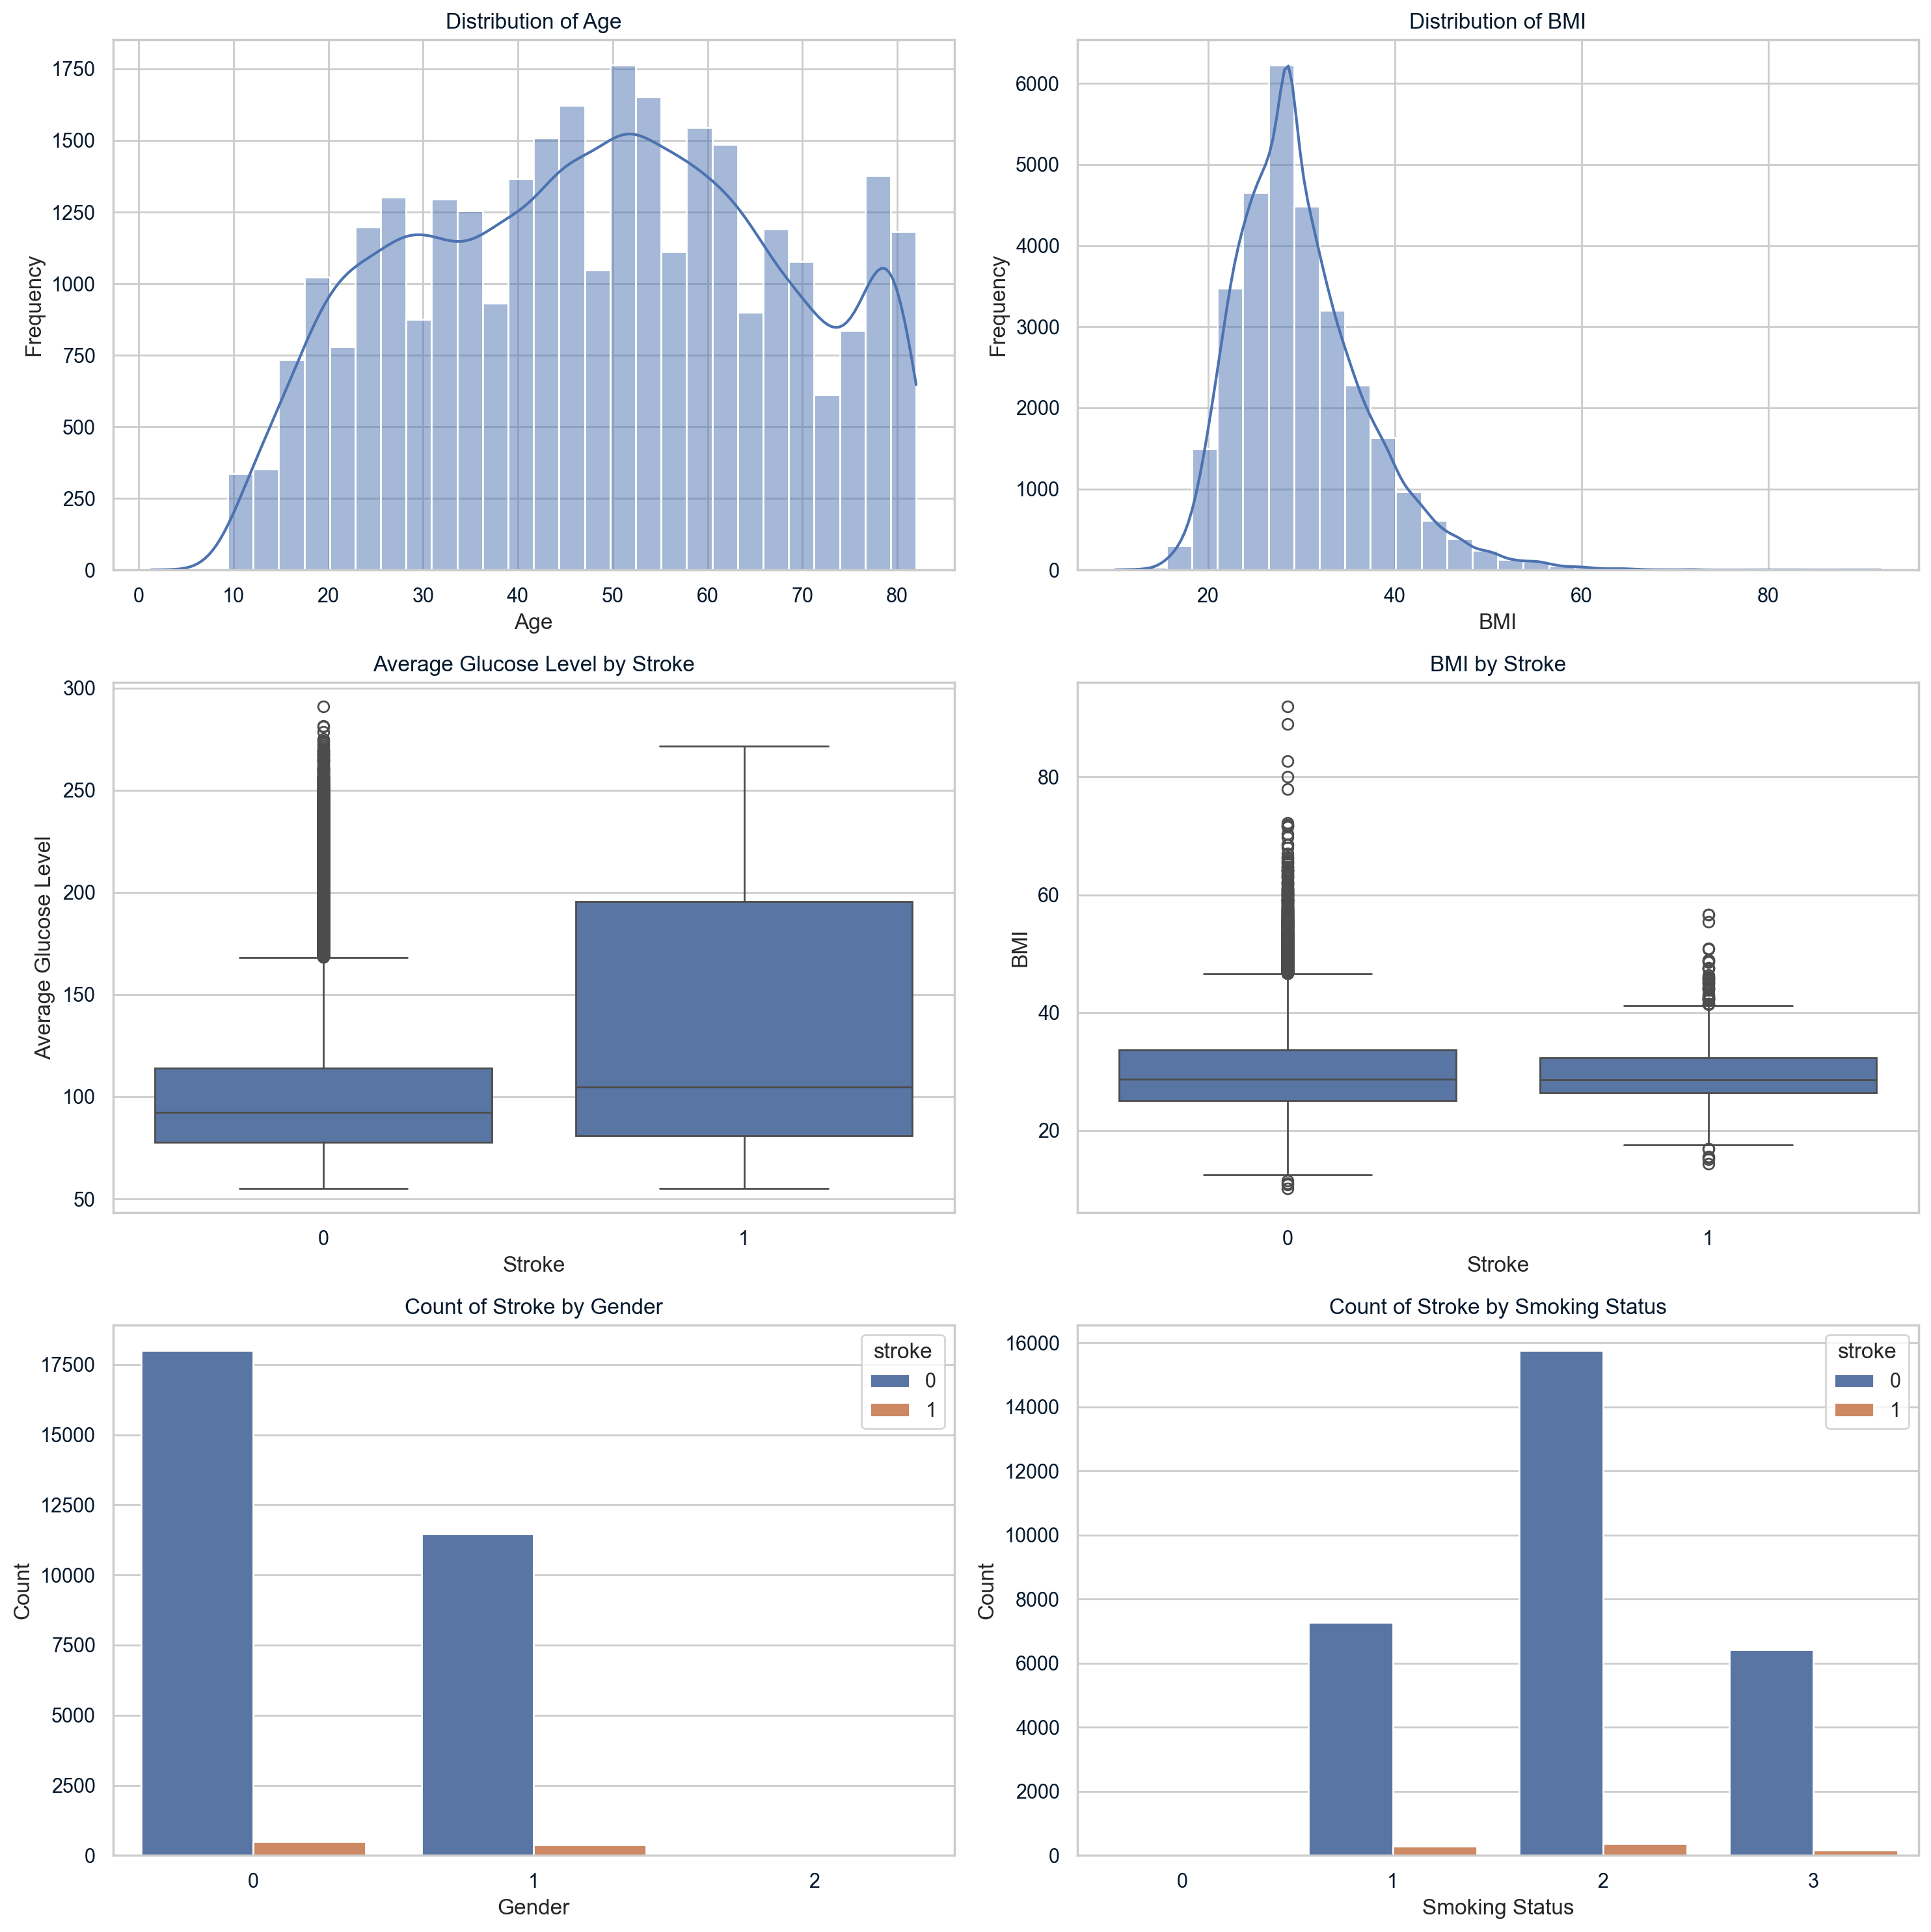

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot 1: Distribution of Age
sns.histplot(clean_data['age'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Age')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: Distribution of BMI
sns.histplot(clean_data['bmi'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of BMI')
axes[0, 1].set_xlabel('BMI')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: Average Glucose Level by Stroke
sns.boxplot(x='stroke', y='avg_glucose_level', data=clean_data, ax=axes[1, 0])
axes[1, 0].set_title('Average Glucose Level by Stroke')
axes[1, 0].set_xlabel('Stroke')
axes[1, 0].set_ylabel('Average Glucose Level')

# Plot 4: BMI by Stroke
sns.boxplot(x='stroke', y='bmi', data=clean_data, ax=axes[1, 1])
axes[1, 1].set_title('BMI by Stroke')
axes[1, 1].set_xlabel('Stroke')
axes[1, 1].set_ylabel('BMI')

# Plot 5: Count of Stroke by Gender
sns.countplot(x='gender', hue='stroke', data=clean_data, ax=axes[2, 0])
axes[2, 0].set_title('Count of Stroke by Gender')
axes[2, 0].set_xlabel('Gender')
axes[2, 0].set_ylabel('Count')

# Plot 6: Count of Stroke by Smoking Status
sns.countplot(x='smoking_status', hue='stroke', data=clean_data, ax=axes[2, 1])
axes[2, 1].set_title('Count of Stroke by Smoking Status')
axes[2, 1].set_xlabel('Smoking Status')
axes[2, 1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

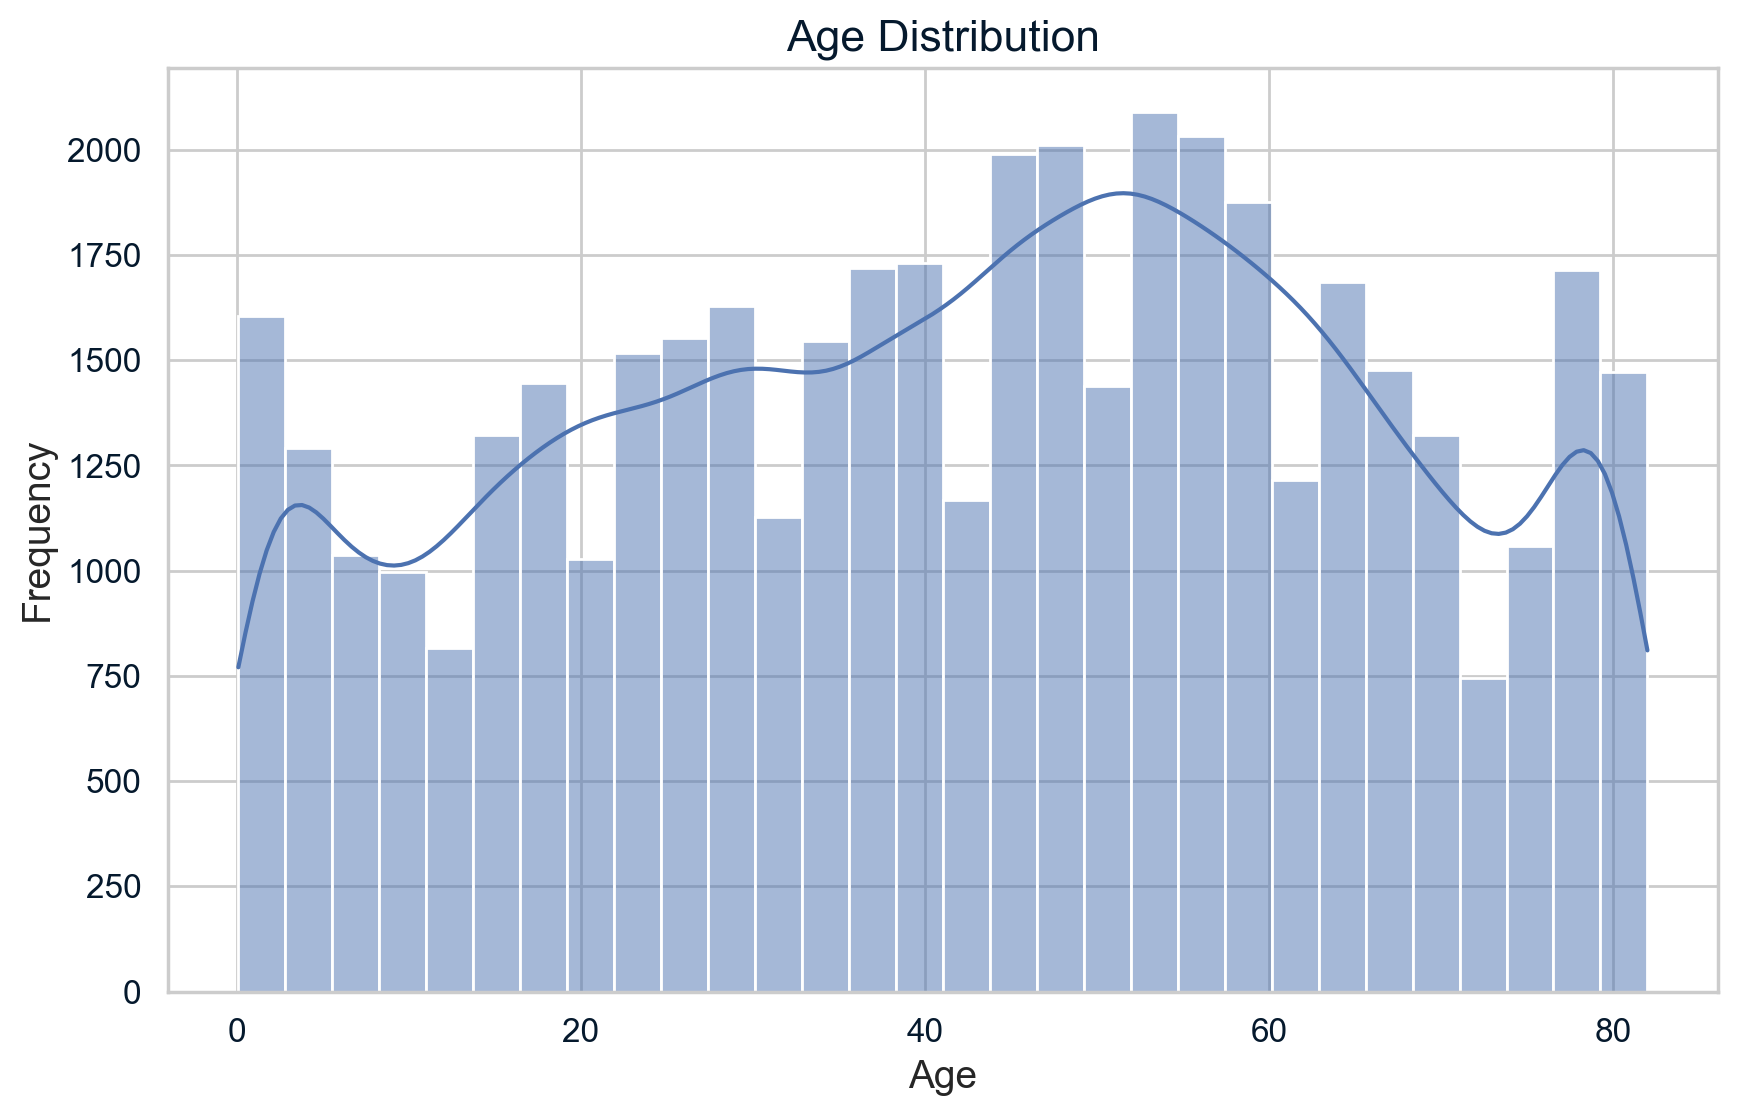

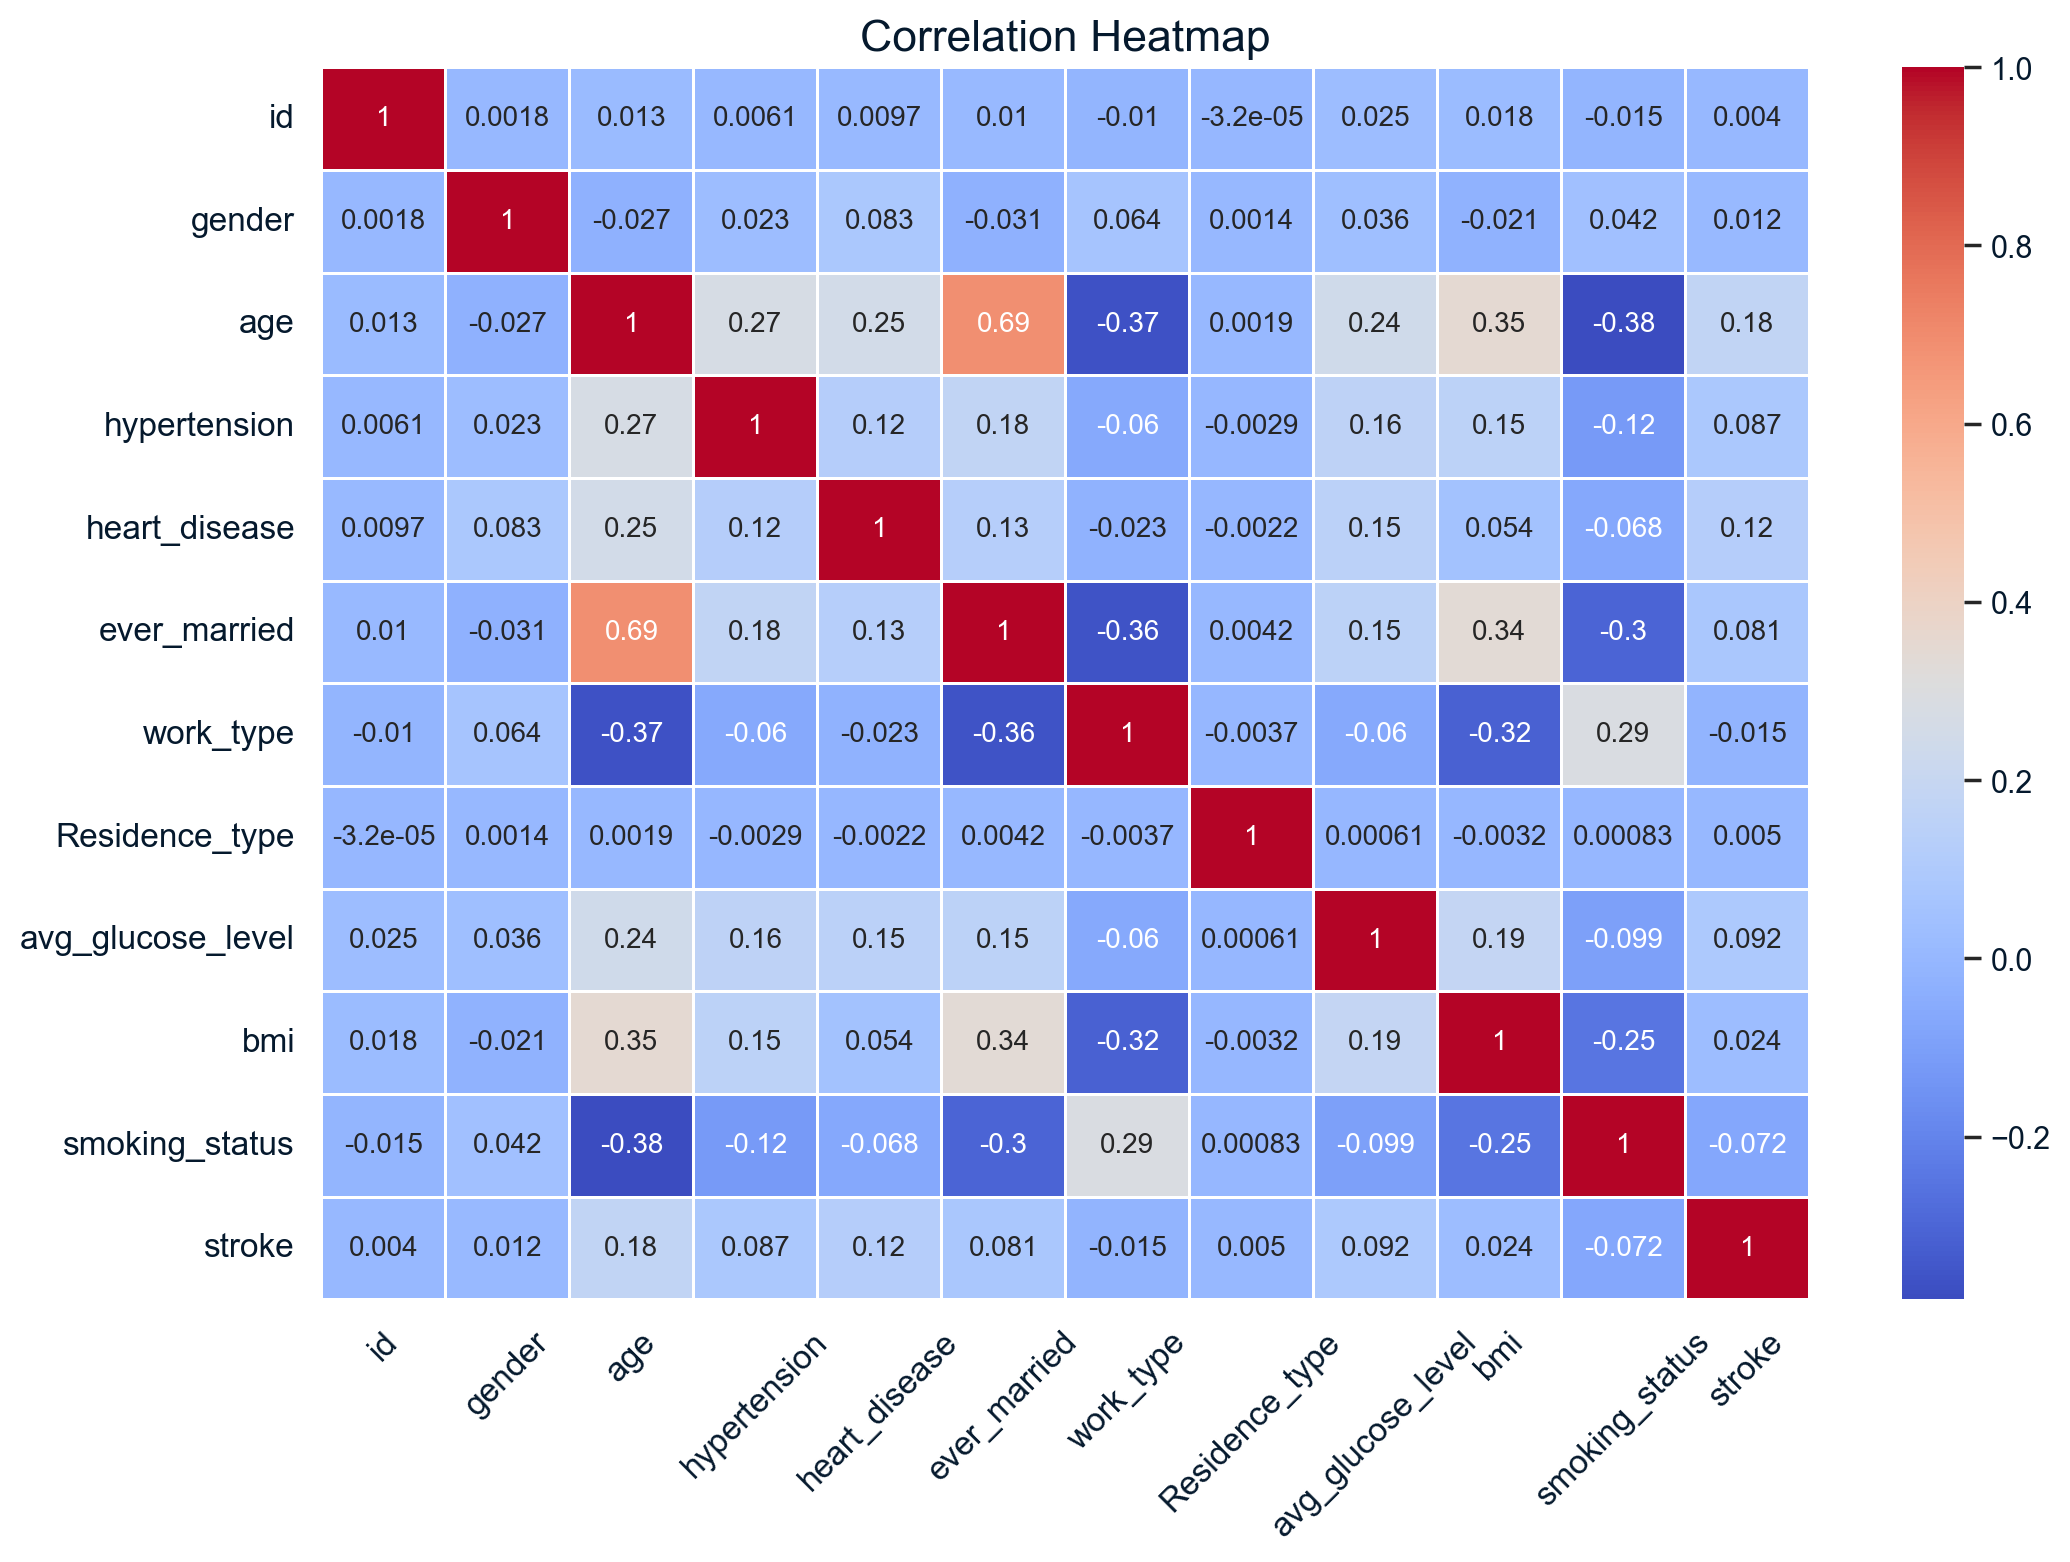

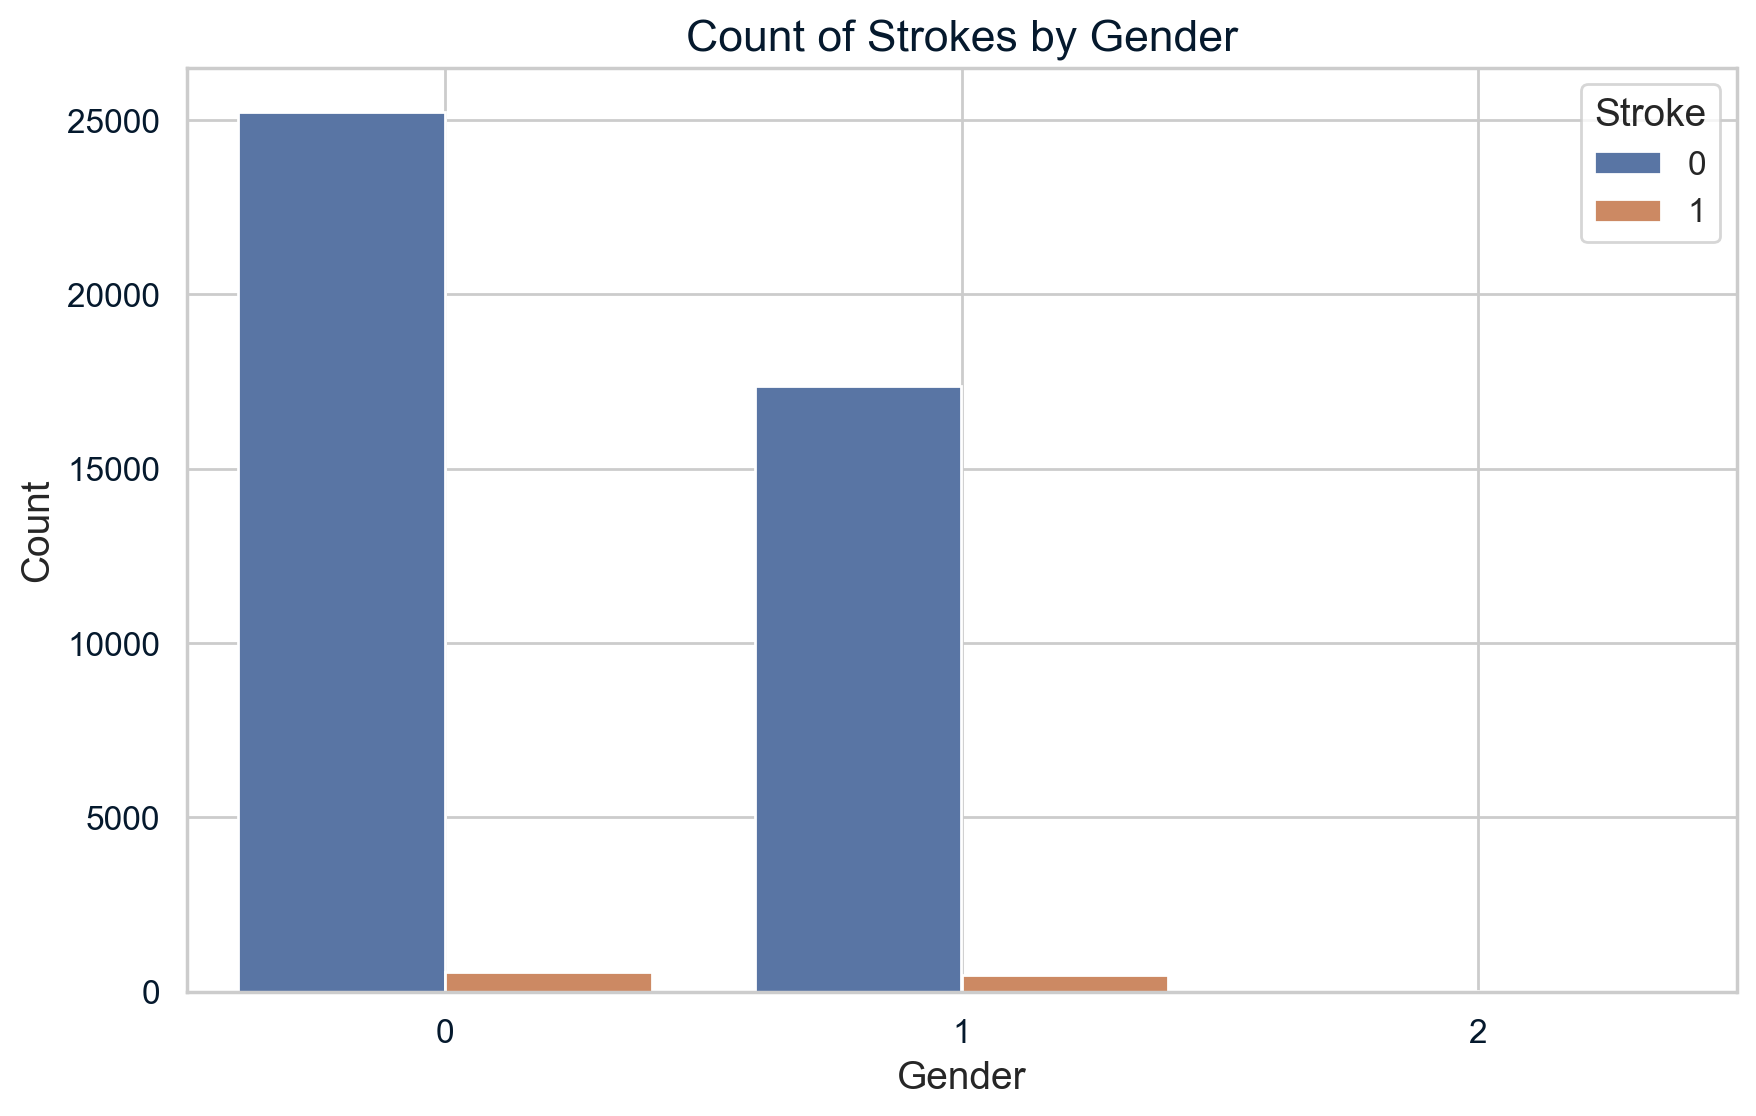

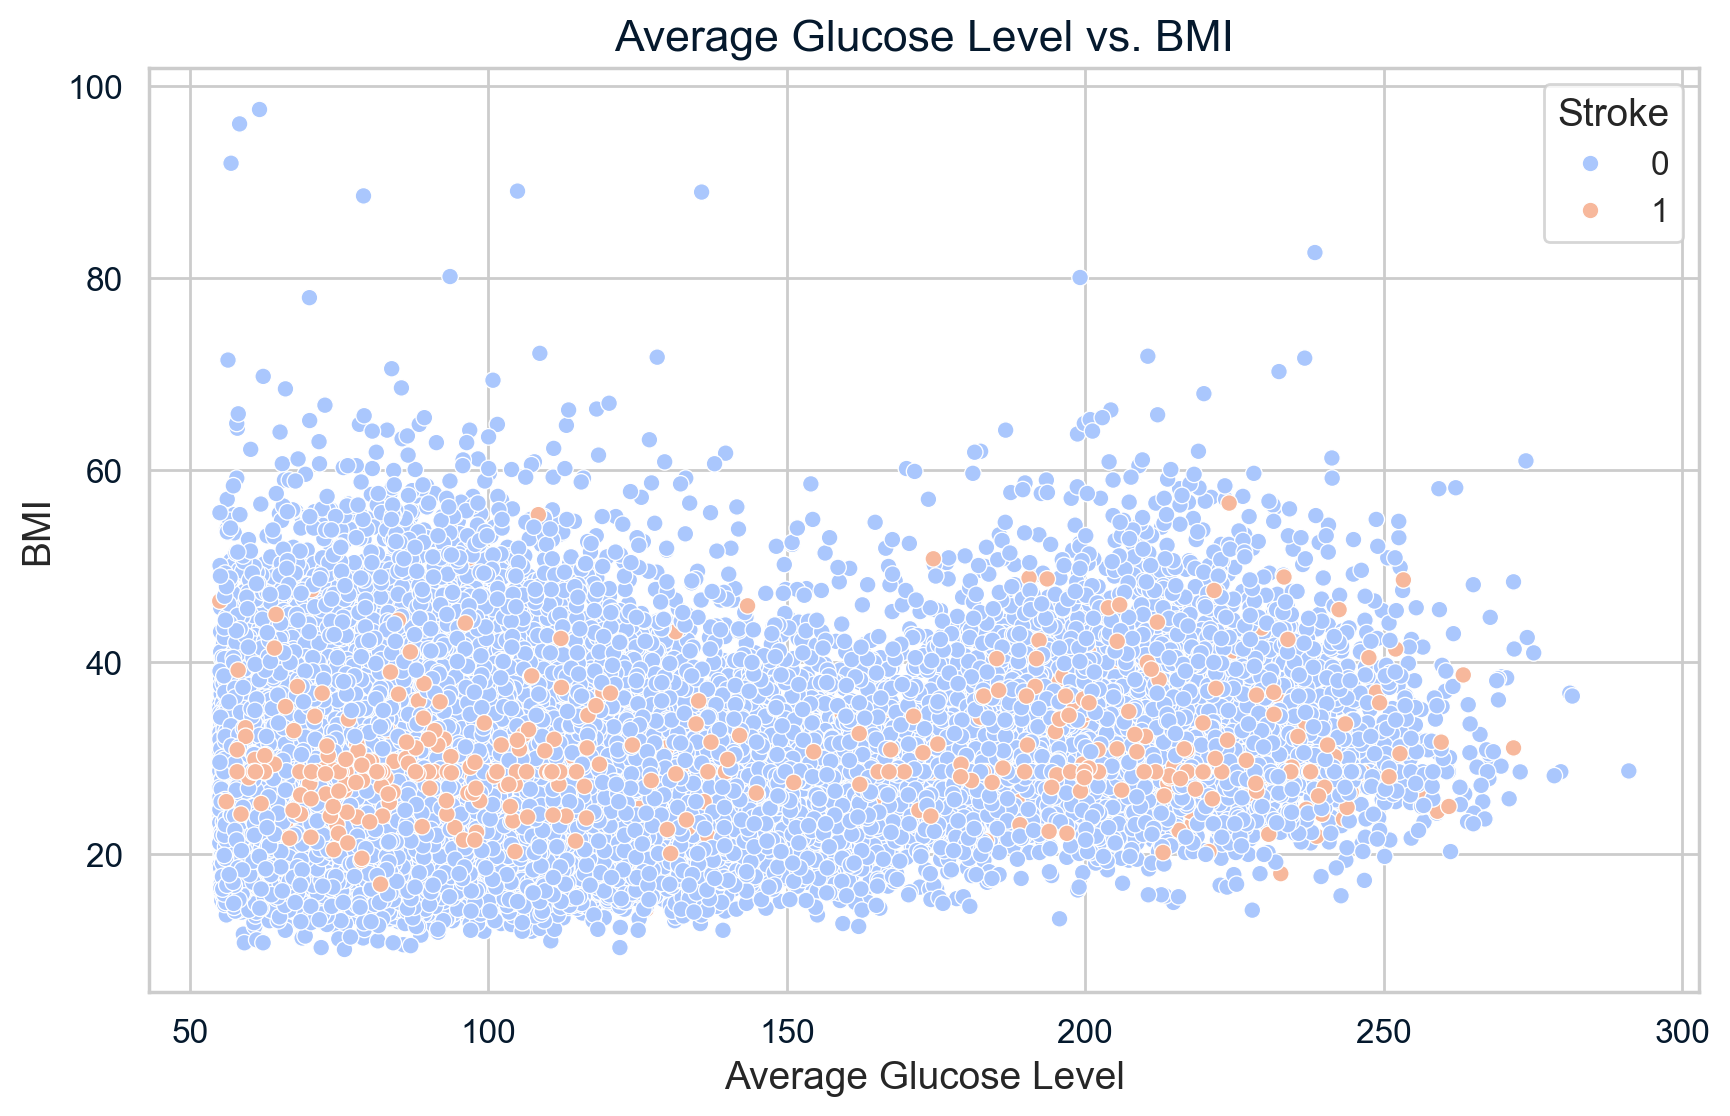

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=30, kde=True)
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# Explanation: 
# This histogram shows the distribution of ages in the dataset. 
# The KDE (Kernel Density Estimate) line provides a smoothed version of the histogram, 
# making it easier to see the overall shape of the distribution.

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

# Explanation: 
# This heatmap displays the correlation coefficients between different features in the dataset. 
# A higher absolute value indicates a stronger correlation, with positive values indicating a direct relationship 
# and negative values indicating an inverse relationship.

# Plotting the count of strokes by gender
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='stroke', data=data)
plt.title('Count of Strokes by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Stroke', loc='upper right', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.show()

# Explanation: 
# This count plot shows the number of stroke cases for each gender. 
# It helps to visualize if there is a significant difference in stroke occurrences between different genders.

# Plotting the average glucose level vs. BMI, colored by stroke
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_glucose_level', y='bmi', hue='stroke', data=data, palette='coolwarm')
plt.title('Average Glucose Level vs. BMI', fontsize=16)
plt.xlabel('Average Glucose Level', fontsize=14)
plt.ylabel('BMI', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Stroke', loc='upper right', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.show()

# Explanation: 
# This scatter plot shows the relationship between average glucose level and BMI, 
# with points colored by stroke occurrence. 
# It helps to identify any patterns or clusters that might indicate a higher risk of stroke based on these two features.

In [33]:
# create the  object with the desired sampling strategy.
smote = SMOTE(sampling_strategy='minority')

# Correcting the use of SMOTE with fit_resample()
X, y = smote.fit_resample(clean_data.loc[:, clean_data.columns != 'stroke'], clean_data['stroke'])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (58962, 10)
Shape of y: (58962,)


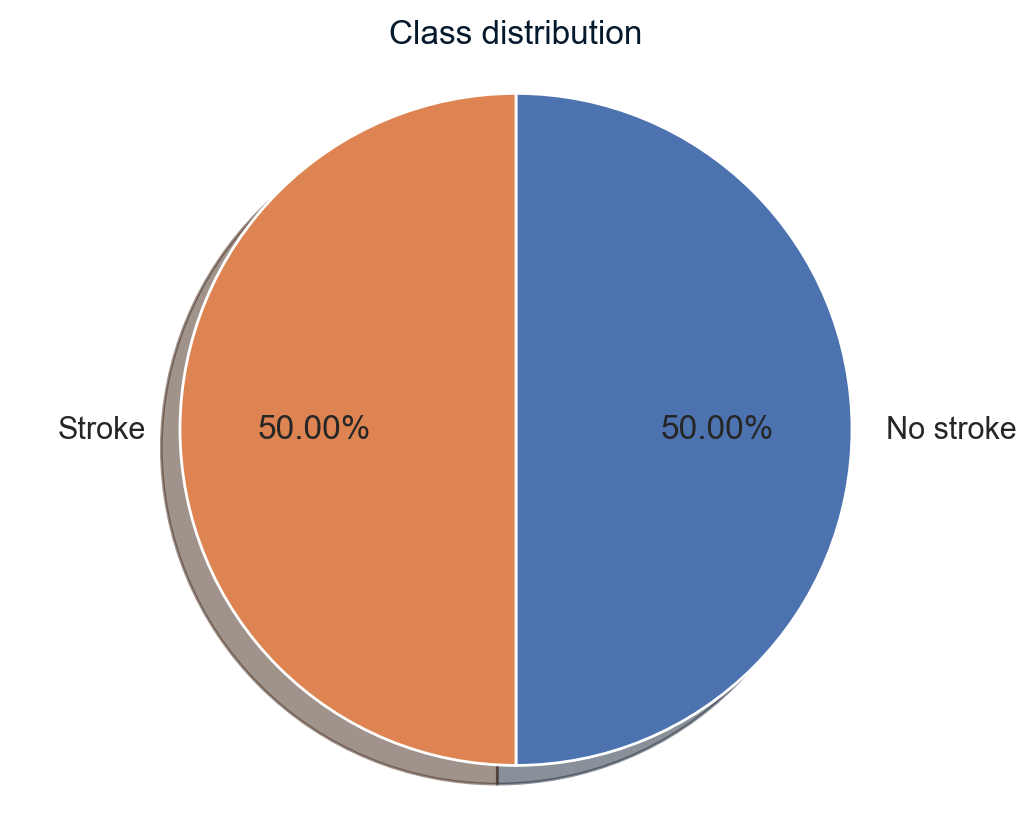

# samples associated with no stroke: 29481
# samples associated with stroke: 29481


In [34]:
_, class_counts = np.unique(y, return_counts=True)
class_names = ['No stroke', 'Stroke']
fig, ax = plt.subplots()
ax.pie(class_counts, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_counts[0]))
print("# samples associated with stroke: {}".format(class_counts[1]))

In [35]:
def split_train_valid_test(X,y,test_size=0.1,random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=test_size/(1-test_size), random_state=random_state, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X,y,test_size=0.1,random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0],train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0],valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0],test_counts[1]))

[train] # class 0: 23584 | # class 1: 23584
[valid] # class 0: 2948 | # class 1: 2949
[test]  # class 0: 2949 | # class 1: 2948


In [36]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

In [37]:
def calc_sens_spec(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    # calculate the sensitivity
    sensitivity = TP / (TP + FN)
    # calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity

In [38]:
start = timer.time()
svm_model = SVC(kernel='rbf',probability=True)
svm_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_svm = svm_model.predict(X_test_std)
y_svm_prob = svm_model.predict_proba(X_test_std)

Finished training within 194.62 seconds


Classification report for SVM: 
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      2949
           1       0.81      0.88      0.85      2948

    accuracy                           0.84      5897
   macro avg       0.84      0.84      0.84      5897
weighted avg       0.84      0.84      0.84      5897

Confusion matrix for SVM: 
[[2351  598]
 [ 342 2606]]
Accuracy score for SVM: 0.84
Precision score for SVM: 0.81
Recall score for SVM: 0.88
F1 score for SVM: 0.85
Sensitivity score for SVM: 0.88
Specitivity score for SVM: 0.80
AUC score for SVM: 0.91


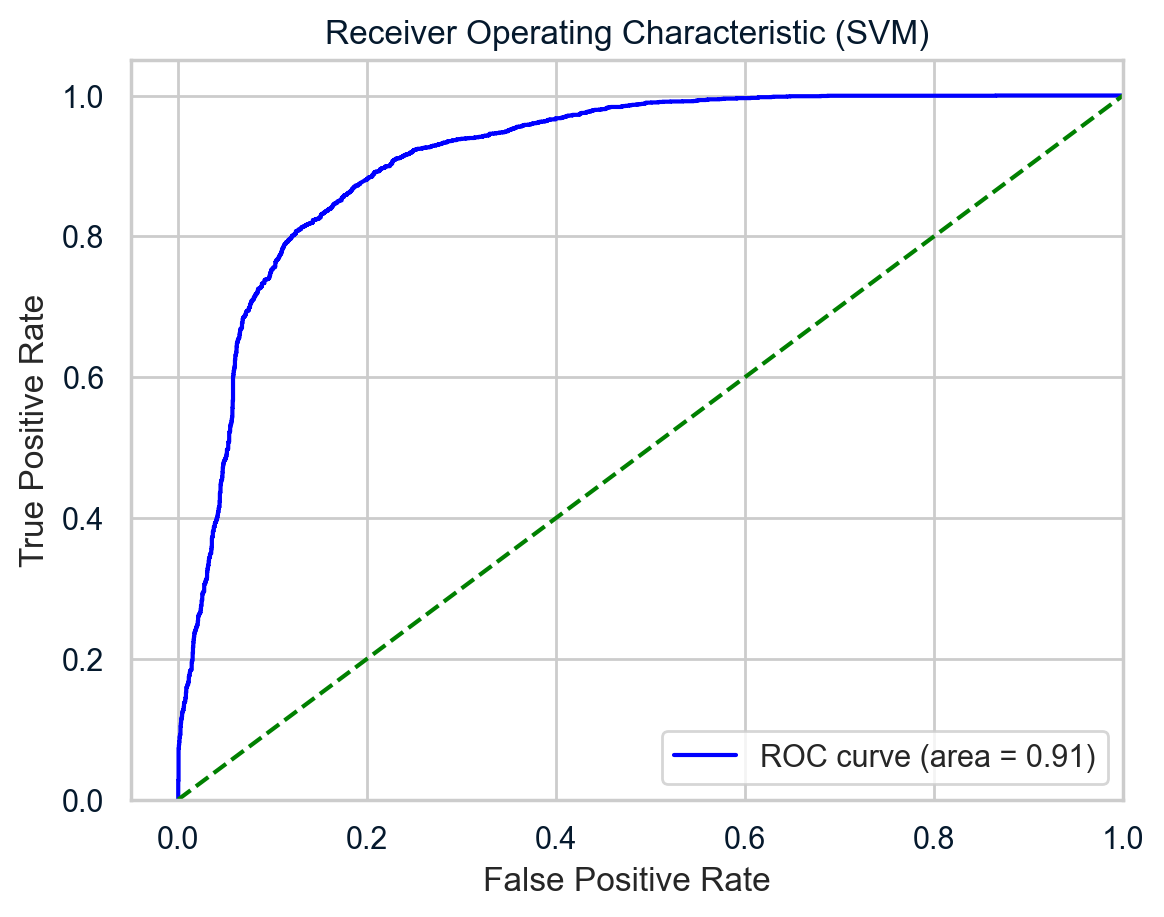

In [39]:
print("Classification report for SVM: \n{}".format(classification_report(y_test,y_svm)))
print("Confusion matrix for SVM: \n{}".format(confusion_matrix(y_test,y_svm)))
print("Accuracy score for SVM: {:.2f}".format(accuracy_score(y_test,y_svm)))

# calculate precision, recall, and f1 scores
prec_svm = precision_score(y_test,y_svm)
rec_svm = recall_score(y_test,y_svm)
f1_svm = f1_score(y_test,y_svm)
print("Precision score for SVM: {:.2f}".format(prec_svm))
print("Recall score for SVM: {:.2f}".format(rec_svm))
print("F1 score for SVM: {:.2f}".format(f1_svm))

# calculate sensitivity, specificity, and auc
sens_svm,spec_svm = calc_sens_spec(y_test,y_svm)
fpr, tpr, _ = roc_curve(y_test,  y_svm_prob[:,1])
auc_svm = roc_auc_score(y_test, y_svm_prob[:,1])
print("Sensitivity score for SVM: {:.2f}".format(sens_svm))
print("Specitivity score for SVM: {:.2f}".format(spec_svm))
print("AUC score for SVM: {:.2f}".format(auc_svm))

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc="lower right")
plt.show()

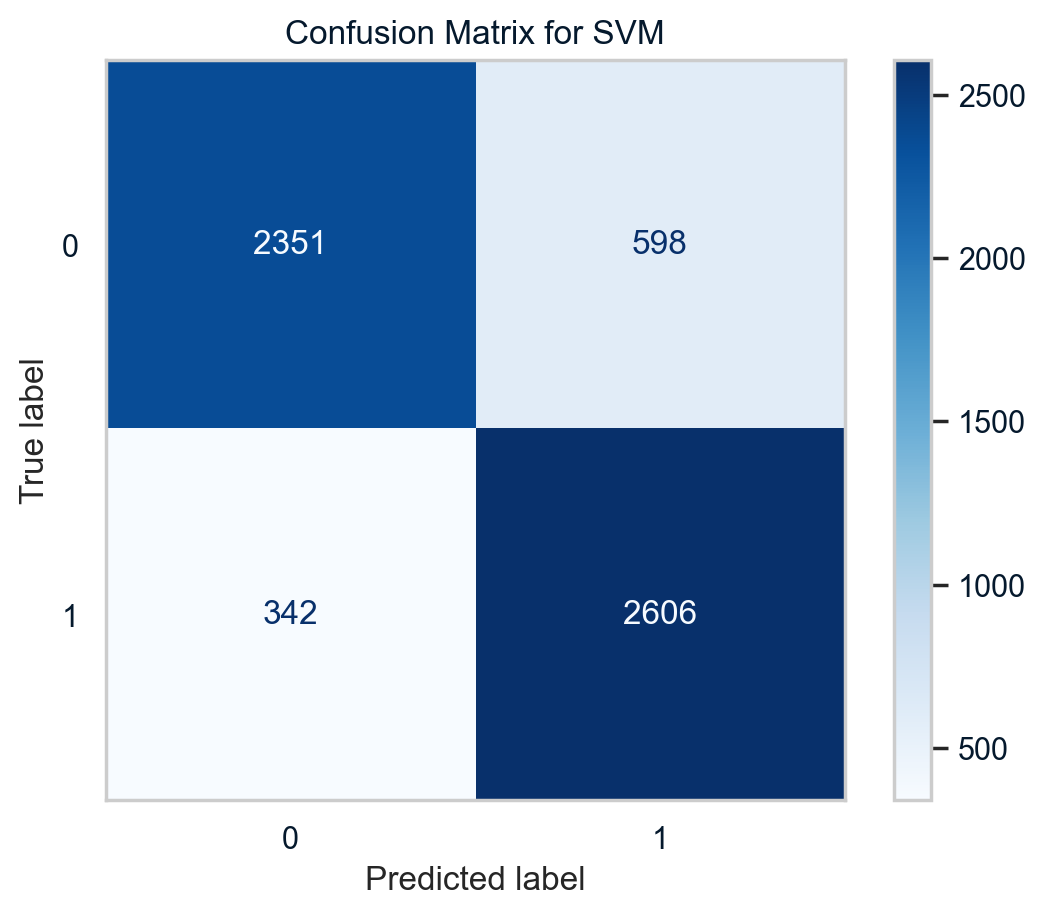

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_svm, ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix for SVM')

# Remove grid lines
ax.grid(False)
plt.show()


In [41]:
start = timer.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_gnb = gnb_model.predict(X_test_std)
y_gnb_prob = gnb_model.predict_proba(X_test_std)

Finished training within 0.01 seconds


Classification report for GNB: 
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      2949
           1       0.74      0.81      0.77      2948

    accuracy                           0.76      5897
   macro avg       0.76      0.76      0.76      5897
weighted avg       0.76      0.76      0.76      5897

Confusion matrix for GNB: 
[[2098  851]
 [ 559 2389]]
Accuracy score for GNB: 0.76
Precision score for GNB: 0.74
Recall score for GNB: 0.81
F1 score for GNB: 0.77
Sensitivity score for GNB: 0.81
Specitivity score for GNB: 0.71
AUC score for GNB: 0.83


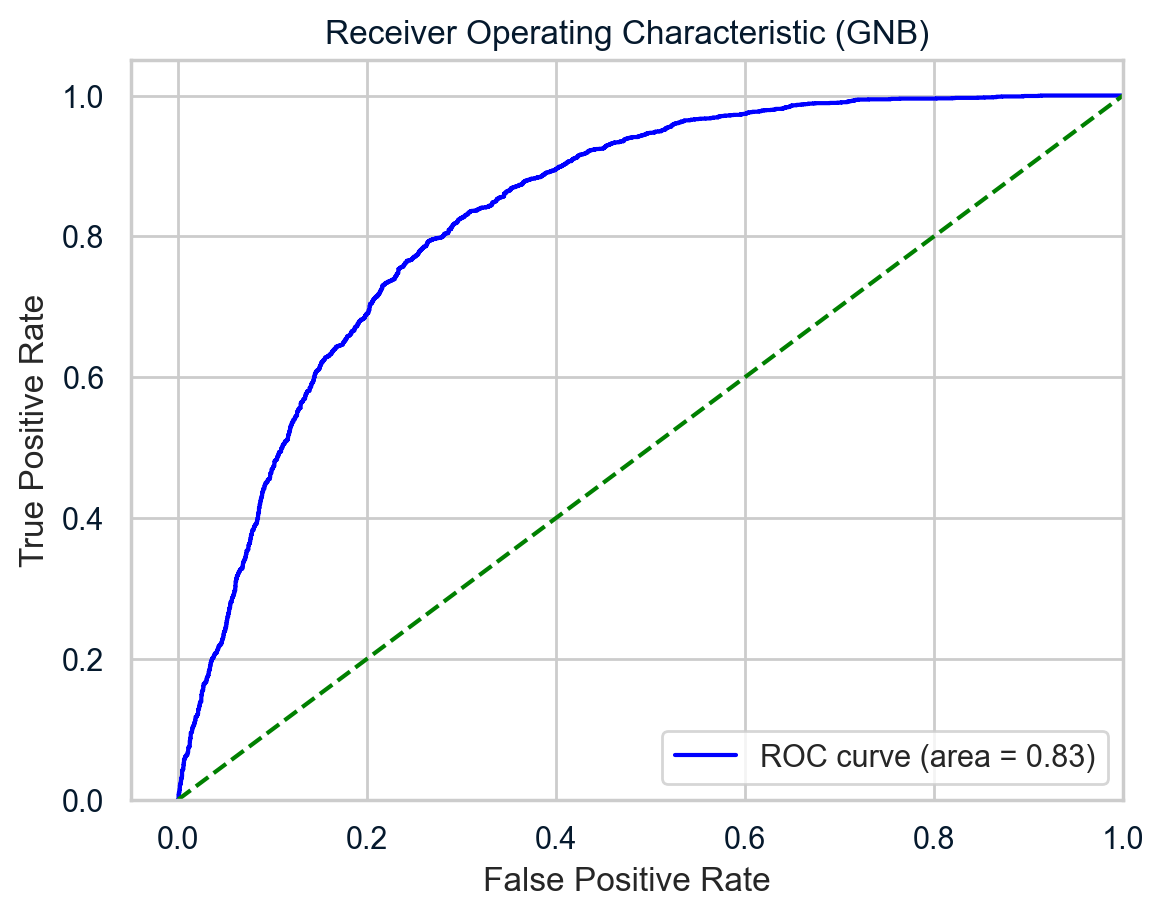

In [42]:
print("Classification report for GNB: \n{}".format(classification_report(y_test,y_gnb)))
print("Confusion matrix for GNB: \n{}".format(confusion_matrix(y_test,y_gnb)))
print("Accuracy score for GNB: {:.2f}".format(accuracy_score(y_test,y_gnb)))
# calculate precision, recall, and f1 scores
prec_gnb = precision_score(y_test,y_gnb)
rec_gnb = recall_score(y_test,y_gnb)
f1_gnb = f1_score(y_test,y_gnb)
print("Precision score for GNB: {:.2f}".format(prec_gnb))
print("Recall score for GNB: {:.2f}".format(rec_gnb))
print("F1 score for GNB: {:.2f}".format(f1_gnb))
# calculate sensitivity, specificity, and auc
sens_gnb,spec_gnb = calc_sens_spec(y_test,y_gnb)
fpr, tpr, _ = roc_curve(y_test,  y_gnb_prob[:,1])
auc_gnb = roc_auc_score(y_test, y_gnb_prob[:,1])
print("Sensitivity score for GNB: {:.2f}".format(sens_gnb))
print("Specitivity score for GNB: {:.2f}".format(spec_gnb))
print("AUC score for GNB: {:.2f}".format(auc_gnb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_gnb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (GNB)')
ax.legend(loc="lower right")
plt.show()

In [43]:
start = timer.time()
logit_model = LogisticRegression(solver='lbfgs', random_state=42)
logit_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_logit = logit_model.predict(X_test_std)
y_logit_prob = logit_model.predict_proba(X_test_std)

Finished training within 0.13 seconds


Classification report for LR: 
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      2949
           1       0.77      0.80      0.78      2948

    accuracy                           0.78      5897
   macro avg       0.78      0.78      0.78      5897
weighted avg       0.78      0.78      0.78      5897

Confusion matrix for LR: 
[[2227  722]
 [ 584 2364]]
Accuracy score for LR: 0.78
Precision score for LR: 0.77
Recall score for LR: 0.80
F1 score for LR: 0.78
Sensitivity score for LR: 0.80
Specitivity score for LR: 0.76
AUC score for LR: 0.86


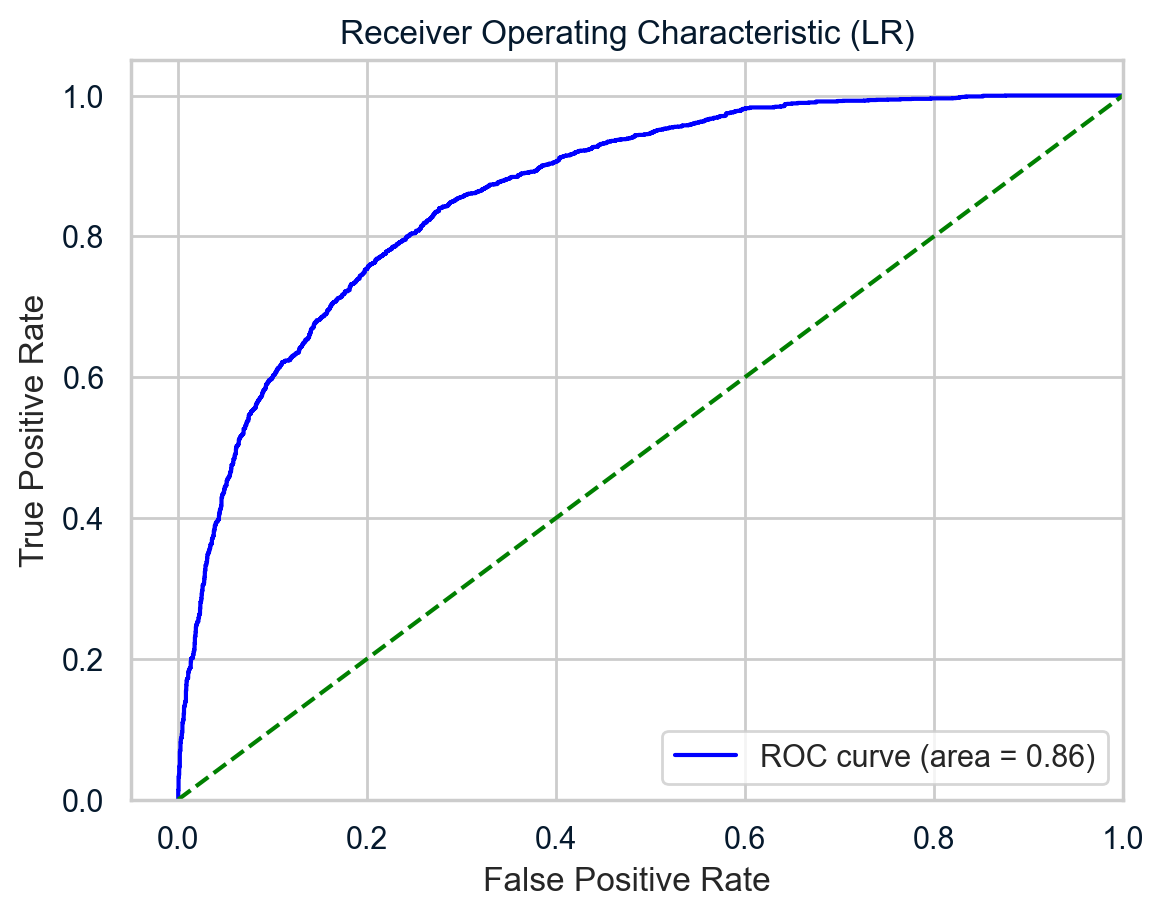

In [44]:
print("Classification report for LR: \n{}".format(classification_report(y_test,y_logit)))
print("Confusion matrix for LR: \n{}".format(confusion_matrix(y_test,y_logit)))
print("Accuracy score for LR: {:.2f}".format(accuracy_score(y_test,y_logit)))
# calculate precision, recall, and f1 scores
prec_logit = precision_score(y_test,y_logit)
rec_logit = recall_score(y_test,y_logit)
f1_logit = f1_score(y_test,y_logit)
print("Precision score for LR: {:.2f}".format(prec_logit))
print("Recall score for LR: {:.2f}".format(rec_logit))
print("F1 score for LR: {:.2f}".format(f1_logit))
# calculate sensitivity, specificity, and auc
sens_logit,spec_logit = calc_sens_spec(y_test,y_logit)
fpr, tpr, _ = roc_curve(y_test,  y_logit_prob[:,1])
auc_logit = roc_auc_score(y_test, y_logit_prob[:,1])
print("Sensitivity score for LR: {:.2f}".format(sens_logit))
print("Specitivity score for LR: {:.2f}".format(spec_logit))
print("AUC score for LR: {:.2f}".format(auc_logit))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_logit)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (LR)')
ax.legend(loc="lower right")
plt.show()

In [45]:
start = timer.time()
dtree_model = DecisionTreeClassifier(random_state=42)
dtree_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_dtree = dtree_model.predict(X_test_std)
y_dtree_prob = dtree_model.predict_proba(X_test_std)

Finished training within 0.23 seconds


Classification report for DT: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2949
           1       0.95      0.96      0.95      2948

    accuracy                           0.95      5897
   macro avg       0.95      0.95      0.95      5897
weighted avg       0.95      0.95      0.95      5897

Confusion matrix for DT: 
[[2788  161]
 [ 116 2832]]
Accuracy score for DT: 0.95
Precision score for DT: 0.95
Recall score for DT: 0.96
F1 score for DT: 0.95
Sensitivity score for DT: 0.96
Specitivity score for DT: 0.95
AUC score for DT: 0.95


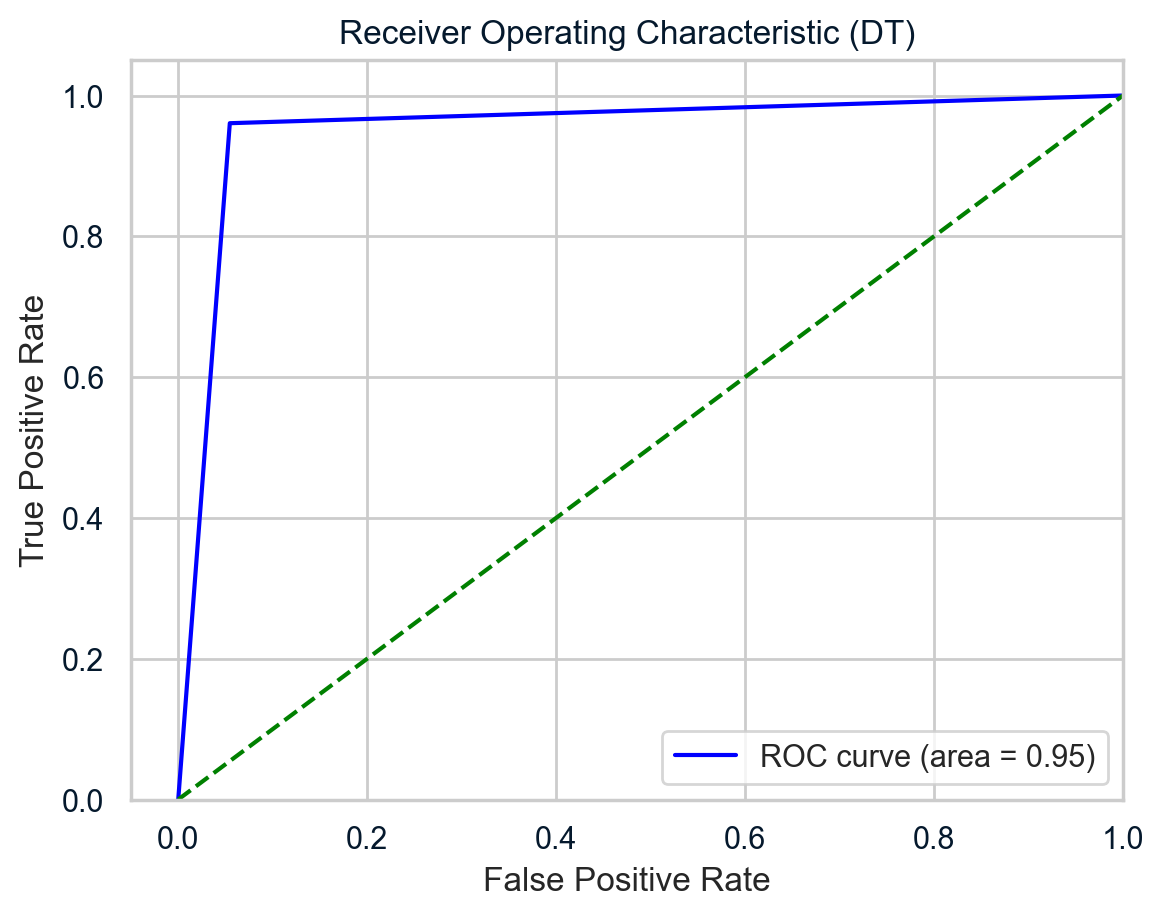

In [46]:
print("Classification report for DT: \n{}".format(classification_report(y_test,y_dtree)))
print("Confusion matrix for DT: \n{}".format(confusion_matrix(y_test,y_dtree)))
print("Accuracy score for DT: {:.2f}".format(accuracy_score(y_test,y_dtree)))
# calculate precision, recall, and f1 scores
prec_dtree = precision_score(y_test,y_dtree)
rec_dtree = recall_score(y_test,y_dtree)
f1_dtree = f1_score(y_test,y_dtree)
print("Precision score for DT: {:.2f}".format(prec_dtree))
print("Recall score for DT: {:.2f}".format(rec_dtree))
print("F1 score for DT: {:.2f}".format(f1_dtree))
# calculate sensitivity, specificity, and auc
sens_dtree,spec_dtree = calc_sens_spec(y_test,y_dtree)
fpr, tpr, _ = roc_curve(y_test,  y_dtree_prob[:,1])
auc_dtree = roc_auc_score(y_test, y_dtree_prob[:,1])
print("Sensitivity score for DT: {:.2f}".format(sens_dtree))
print("Specitivity score for DT: {:.2f}".format(spec_dtree))
print("AUC score for DT: {:.2f}".format(auc_dtree))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_dtree)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (DT)')
ax.legend(loc="lower right")
plt.show()

In [47]:
start = timer.time()
ranfor_model = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_ranfor = ranfor_model.predict(X_test_std)
y_ranfor_prob = ranfor_model.predict_proba(X_test_std)

Finished training within 5.52 seconds


Classification report for RF: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2949
           1       0.97      0.98      0.97      2948

    accuracy                           0.97      5897
   macro avg       0.97      0.97      0.97      5897
weighted avg       0.97      0.97      0.97      5897

Confusion matrix for RF: 
[[2856   93]
 [  60 2888]]
Accuracy score for RF: 0.97
Precision score for RF: 0.97
Recall score for RF: 0.98
F1 score for RF: 0.97
Sensitivity score for RF: 0.98
Specitivity score for RF: 0.97
AUC score for RF: 1.00


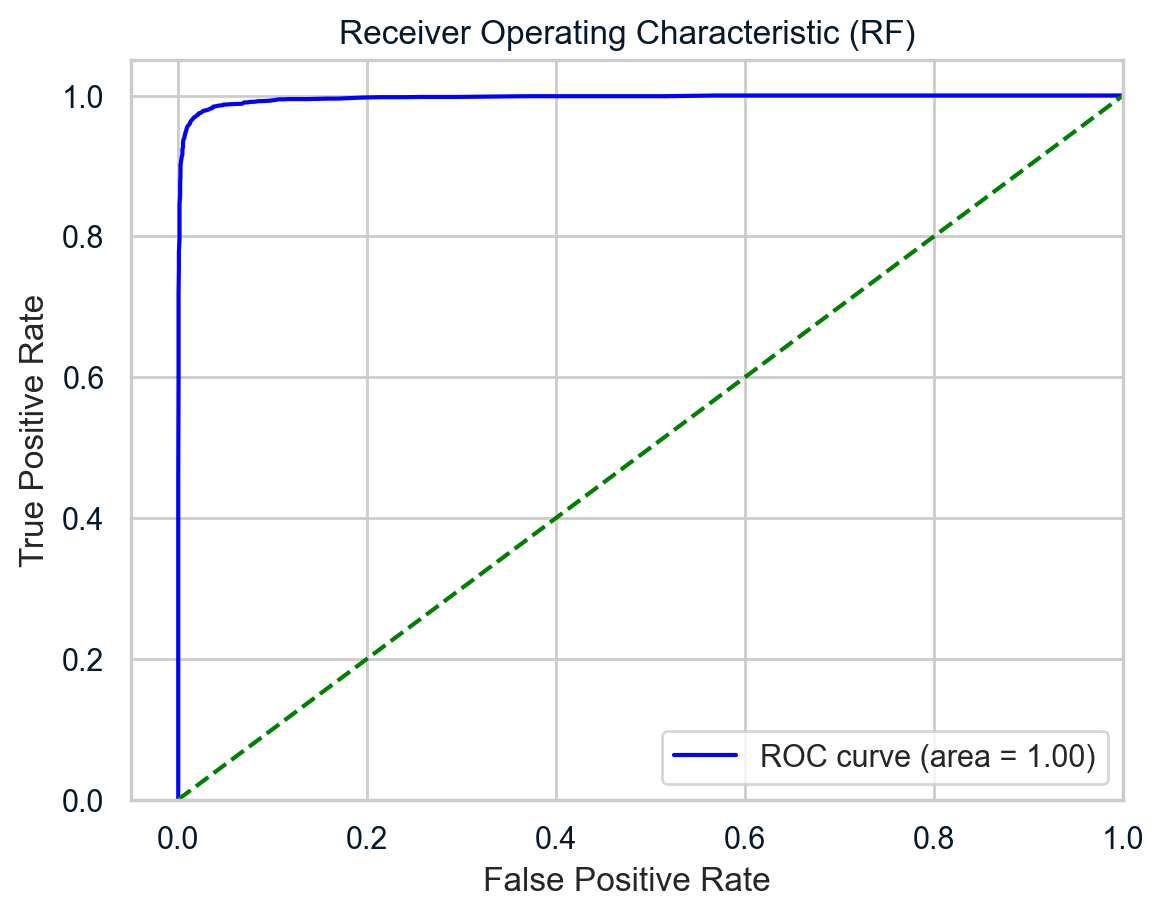

In [48]:
print("Classification report for RF: \n{}".format(classification_report(y_test,y_ranfor)))
print("Confusion matrix for RF: \n{}".format(confusion_matrix(y_test,y_ranfor)))
print("Accuracy score for RF: {:.2f}".format(accuracy_score(y_test,y_ranfor)))
# calculate precision, recall, and f1 scores
prec_ranfor = precision_score(y_test,y_ranfor)
rec_ranfor = recall_score(y_test,y_ranfor)
f1_ranfor = f1_score(y_test,y_ranfor)
print("Precision score for RF: {:.2f}".format(prec_ranfor))
print("Recall score for RF: {:.2f}".format(rec_ranfor))
print("F1 score for RF: {:.2f}".format(f1_ranfor))
# calculate sensitivity, specificity, and auc
sens_ranfor,spec_ranfor = calc_sens_spec(y_test,y_ranfor)
fpr, tpr, _ = roc_curve(y_test,  y_ranfor_prob[:,1])
auc_ranfor = roc_auc_score(y_test, y_ranfor_prob[:,1])
print("Sensitivity score for RF: {:.2f}".format(sens_ranfor))
print("Specitivity score for RF: {:.2f}".format(spec_ranfor))
print("AUC score for RF: {:.2f}".format(auc_ranfor))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_ranfor)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (RF)')
ax.legend(loc="lower right")
plt.show()

In [49]:
start = timer.time()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_xgb = xgb_model.predict(X_test_std)
y_xgb_prob = xgb_model.predict_proba(X_test_std)

Finished training within 0.33 seconds


Classification report for XGB: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2949
           1       0.94      0.96      0.95      2948

    accuracy                           0.95      5897
   macro avg       0.95      0.95      0.95      5897
weighted avg       0.95      0.95      0.95      5897

Confusion matrix for XGB: 
[[2776  173]
 [ 117 2831]]
Accuracy score for XGB: 0.95
Precision score for XGB: 0.94
Recall score for XGB: 0.96
F1 score for XGB: 0.95
Sensitivity score for XGB: 0.96
Specitivity score for XGB: 0.94
AUC score for XGB: 0.99


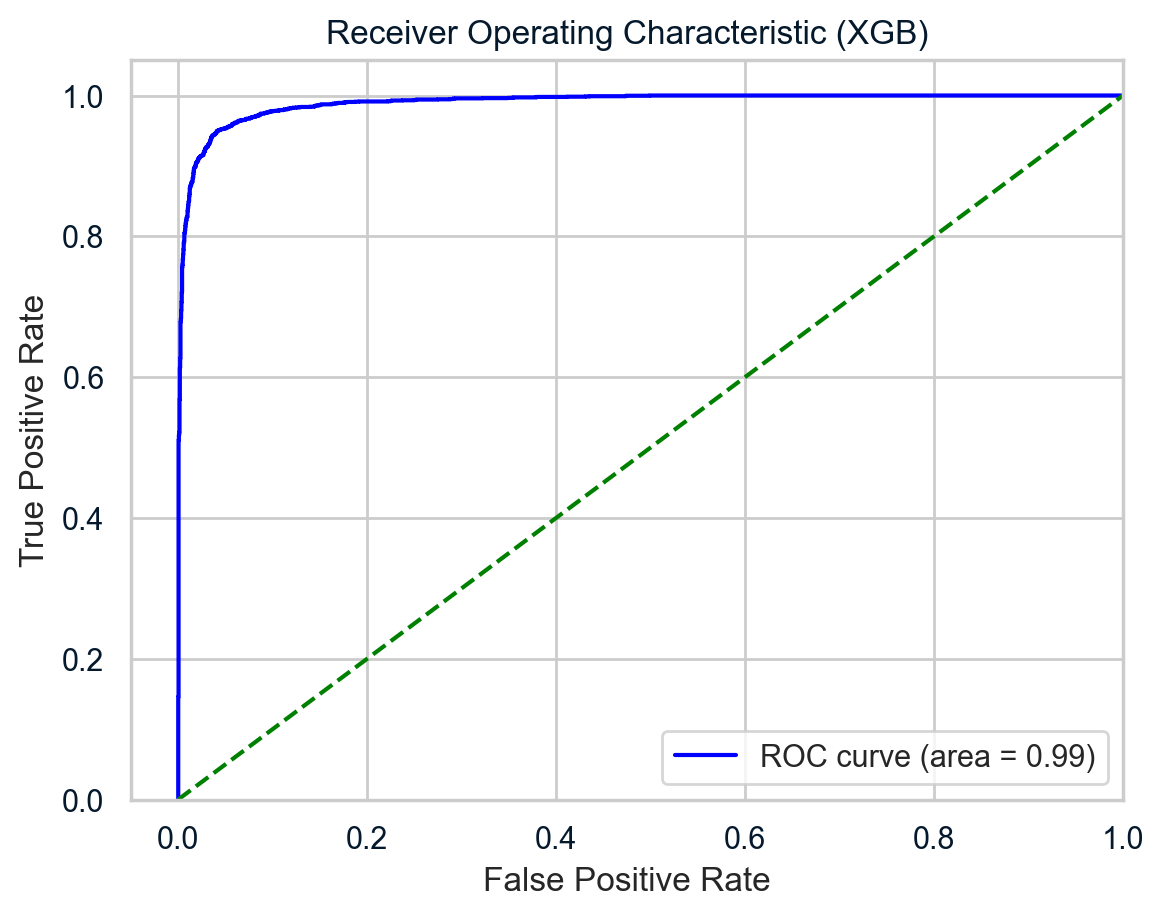

In [50]:
print("Classification report for XGB: \n{}".format(classification_report(y_test,y_xgb)))
print("Confusion matrix for XGB: \n{}".format(confusion_matrix(y_test,y_xgb)))
print("Accuracy score for XGB: {:.2f}".format(accuracy_score(y_test,y_xgb)))
# calculate precision, recall, and f1 scores
prec_xgb = precision_score(y_test,y_xgb)
rec_xgb = recall_score(y_test,y_xgb)
f1_xgb = f1_score(y_test,y_xgb)
print("Precision score for XGB: {:.2f}".format(prec_xgb))
print("Recall score for XGB: {:.2f}".format(rec_xgb))
print("F1 score for XGB: {:.2f}".format(f1_xgb))
# calculate sensitivity, specificity, and auc
sens_xgb,spec_xgb = calc_sens_spec(y_test,y_xgb)
fpr, tpr, _ = roc_curve(y_test,  y_xgb_prob[:,1])
auc_xgb = roc_auc_score(y_test, y_xgb_prob[:,1])
print("Sensitivity score for XGB: {:.2f}".format(sens_xgb))
print("Specitivity score for XGB: {:.2f}".format(spec_xgb))
print("AUC score for XGB: {:.2f}".format(auc_xgb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_xgb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (XGB)')
ax.legend(loc="lower right")
plt.show()

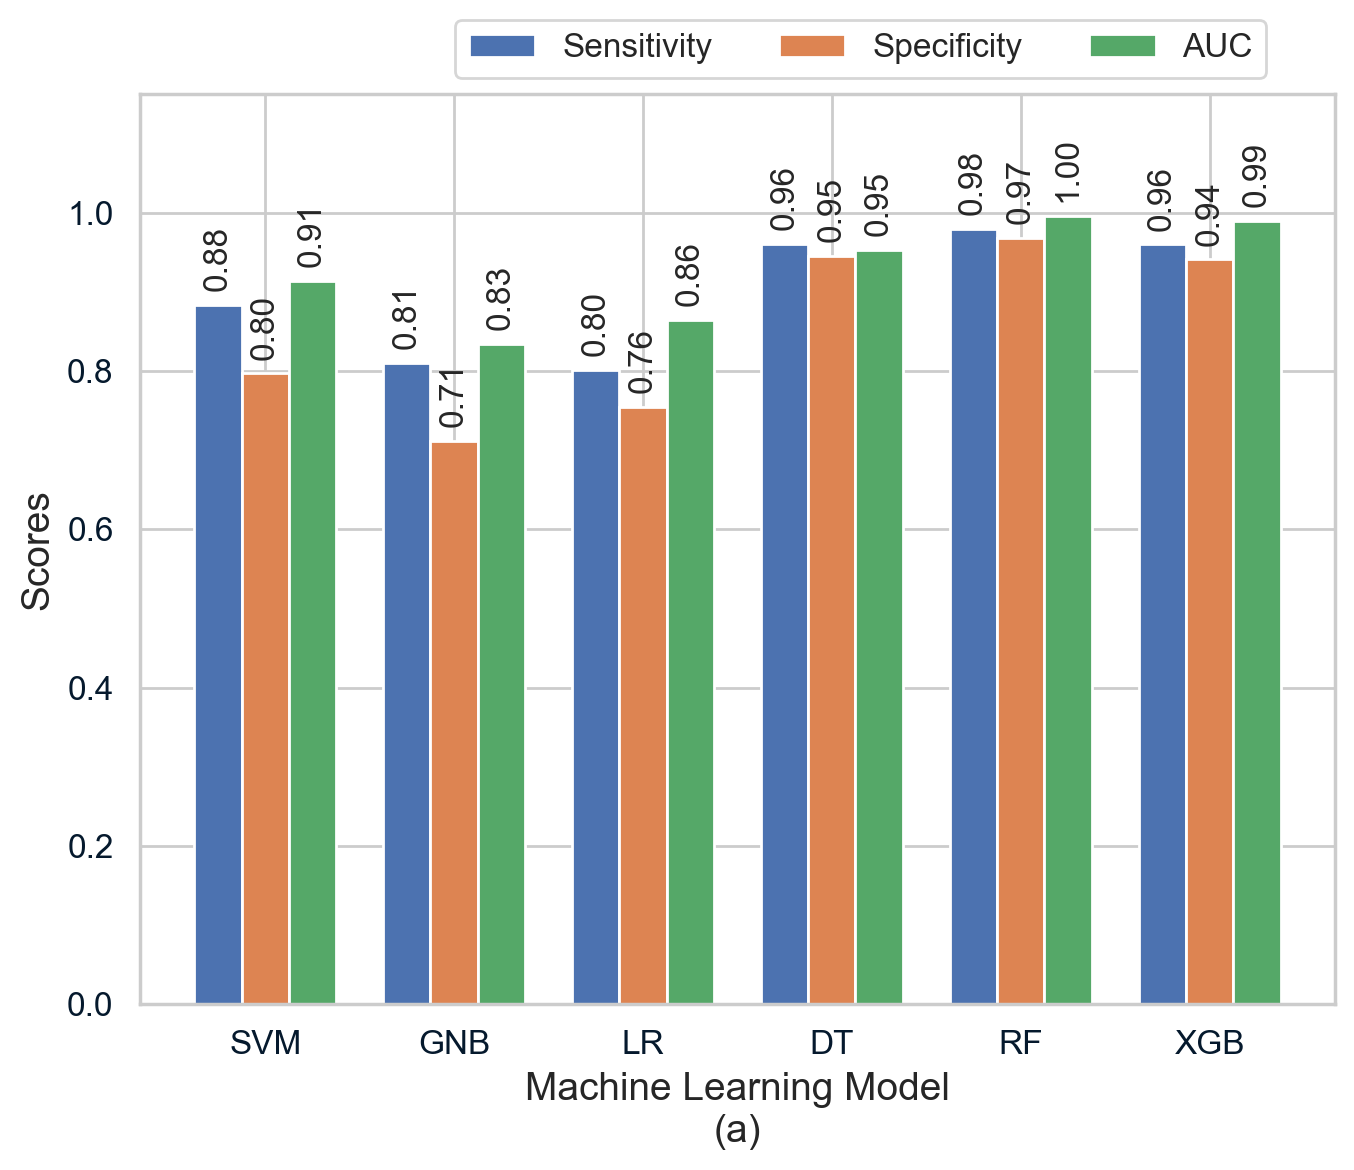

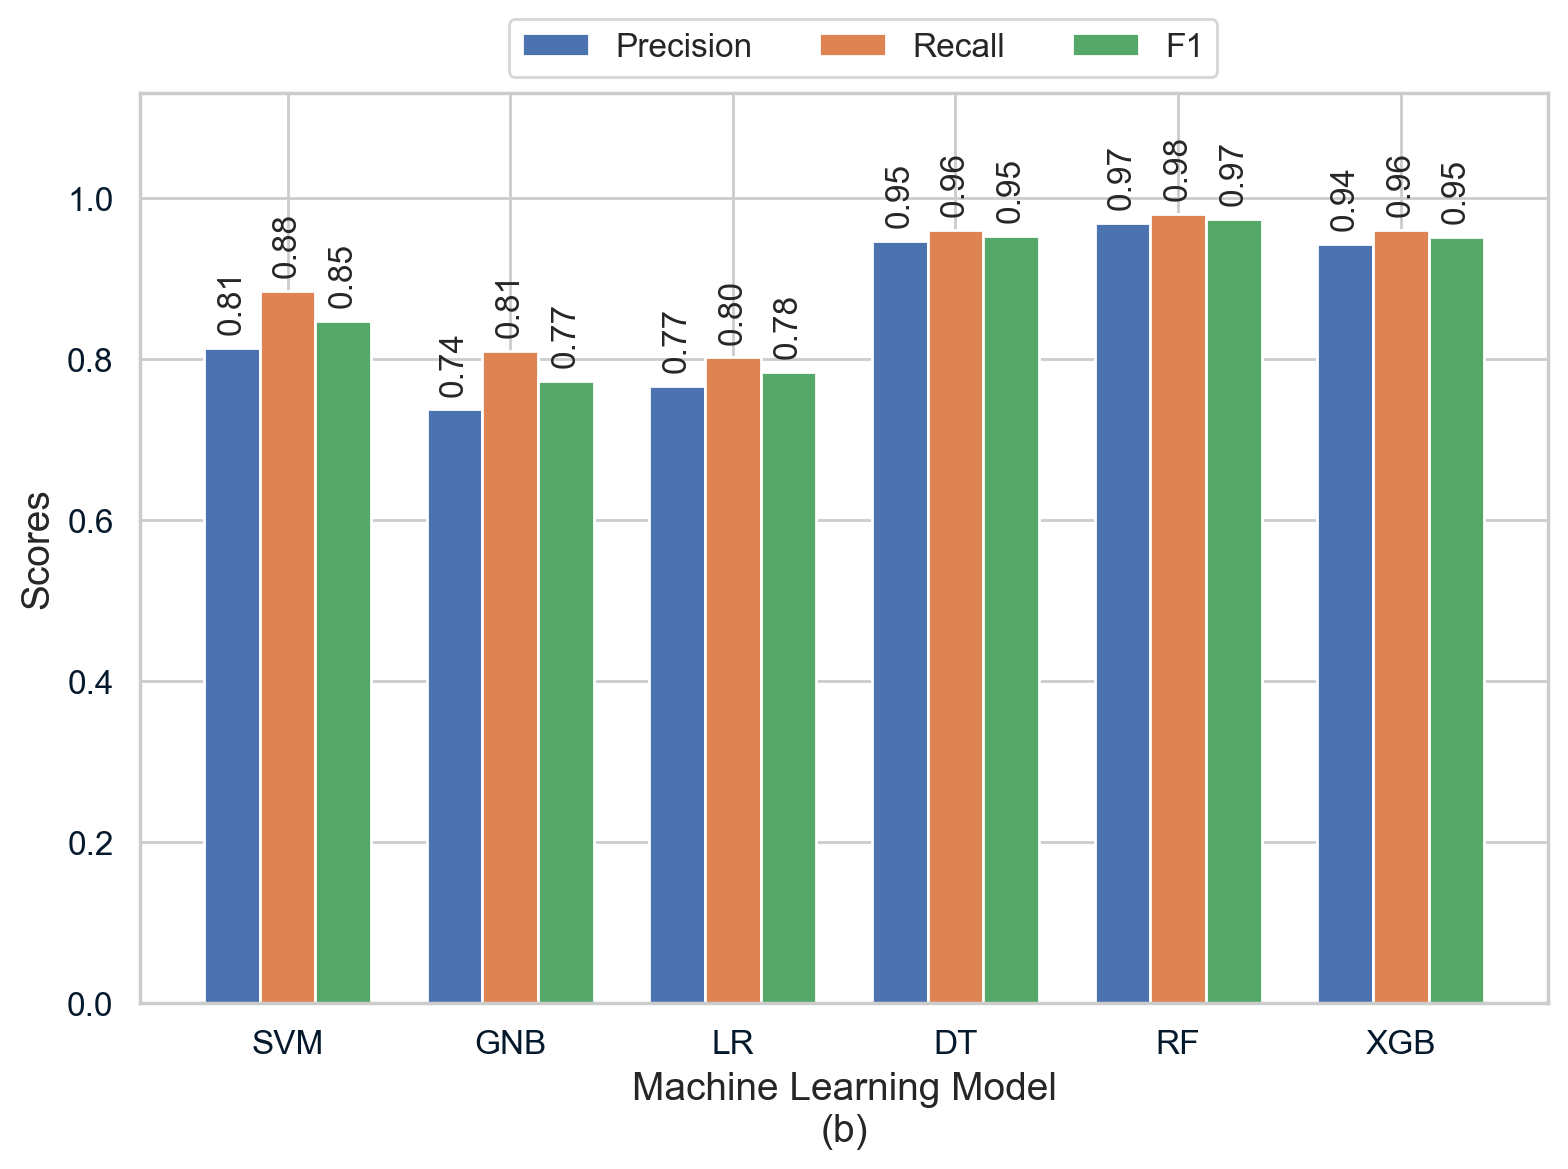

In [51]:
ml_names = ['SVM', 'GNB', 'LR', 'DT', 'RF', 'XGB']
sens_all = [sens_svm, sens_gnb, sens_logit, sens_dtree, sens_ranfor, sens_xgb]
spec_all = [spec_svm, spec_gnb, spec_logit, spec_dtree, spec_ranfor, spec_xgb]
auc_all = [auc_svm, auc_gnb, auc_logit, auc_dtree, auc_ranfor, auc_xgb]

prec_all = [prec_svm, prec_gnb, prec_logit, prec_dtree, prec_ranfor, prec_xgb]
rec_all = [rec_svm, rec_gnb, rec_logit, rec_dtree, rec_ranfor, rec_xgb]
f1_all = [f1_svm, f1_gnb, f1_logit, f1_dtree, f1_ranfor, f1_xgb]

def autolabel(bars):
    """Attach a text label above each bar in displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=12,
                    rotation=90,
                    ha='center', va='bottom')

width = 0.25  # the width of the bars
r1 = np.arange(len(ml_names))  # the label locations
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
# plot sensitivity, specificity, and auc
fig, ax = plt.subplots(figsize=(7,6))
bar1 = ax.bar(r1, sens_all, width, label='Sensitivity')
bar2 = ax.bar(r2, spec_all, width, label='Specificity')
bar3 = ax.bar(r3, auc_all, width, label='AUC')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.15])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n(a)",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("ml_benchmark_auc.pdf", bbox_inches='tight')
plt.show()

# plot sensitivity, specificity, and auc
fig, ax = plt.subplots(figsize=(8,6))
bar1 = ax.bar(r1, prec_all, width, label='Precision')
bar2 = ax.bar(r2, rec_all, width, label='Recall')
bar3 = ax.bar(r3, f1_all, width, label='F1')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.13])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n(b)",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("ml_benchmark_f1.pdf", bbox_inches='tight')
plt.show()

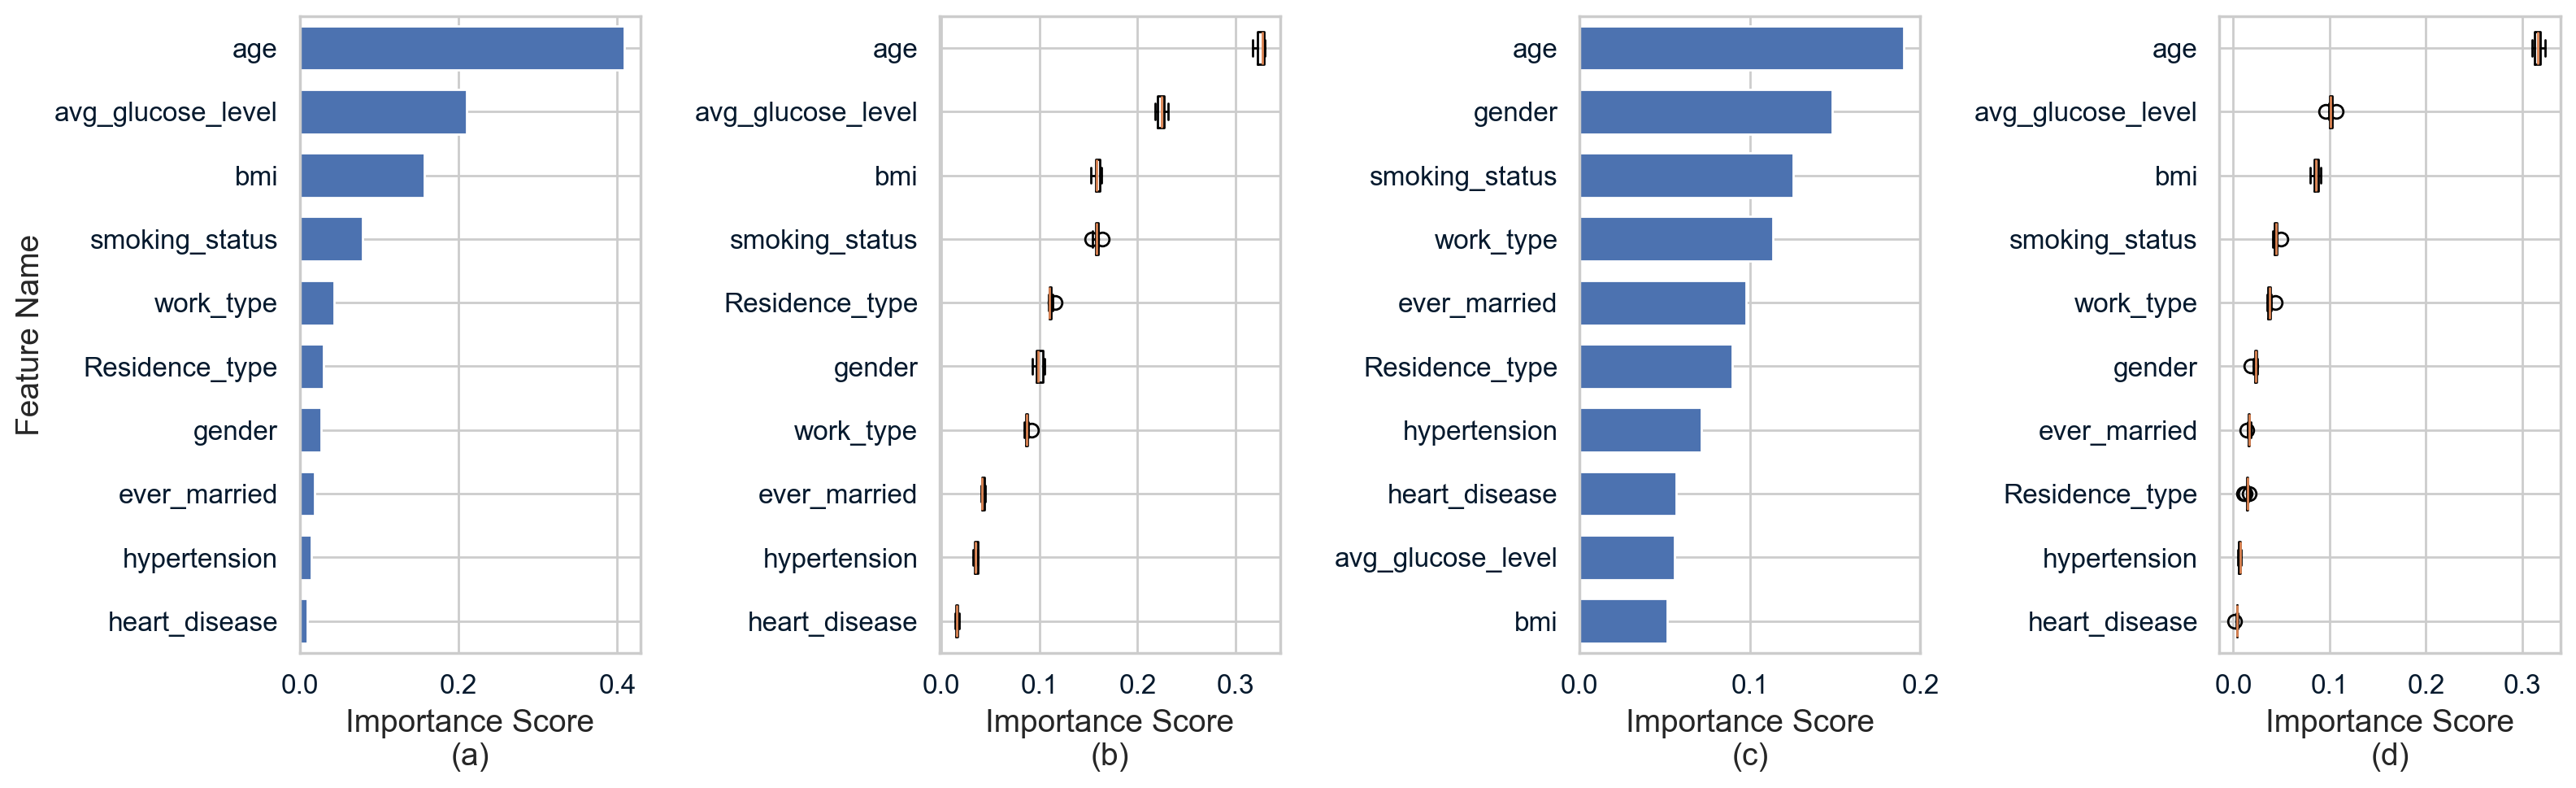

In [52]:
# feature importance from random forest
feature_names = clean_data.columns[:-1].to_numpy()
ranfor_perm_imp = permutation_importance(ranfor_model, X_test_std, y_test, n_repeats=10, random_state=42)
ranfor_perm_sort_idx = ranfor_perm_imp.importances_mean.argsort()

ranfor_tree_sort_idx = np.argsort(ranfor_model.feature_importances_)
ranfor_indices = np.arange(0, len(ranfor_model.feature_importances_)) + 0.5

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
ax1.barh(ranfor_indices,ranfor_model.feature_importances_[ranfor_tree_sort_idx], height=0.7)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel("Importance Score\n(a)",fontsize=14)
ax1.set_ylabel("Feature Name",fontsize=14)
ax1.set_yticklabels(feature_names[ranfor_tree_sort_idx])
ax1.set_yticks(ranfor_indices)
ax1.set_ylim((0, len(ranfor_model.feature_importances_)))
ax2.boxplot(ranfor_perm_imp.importances[ranfor_perm_sort_idx].T,vert=False,labels=feature_names[ranfor_perm_sort_idx])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel("Importance Score\n(b)",fontsize=14)

# feature importance from XGBoost
xgb_perm_imp = permutation_importance(xgb_model, X_test_std, y_test, n_repeats=10, random_state=42)
xgb_perm_sort_idx = xgb_perm_imp.importances_mean.argsort()

xgb_tree_sort_idx = np.argsort(xgb_model.feature_importances_)
xgb_indices = np.arange(0, len(xgb_model.feature_importances_)) + 0.5

ax3.barh(xgb_indices,xgb_model.feature_importances_[xgb_tree_sort_idx], height=0.7)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlabel("Importance Score\n(c)",fontsize=14)
ax3.set_yticklabels(feature_names[xgb_tree_sort_idx])
ax3.set_yticks(xgb_indices)
ax3.set_ylim((0, len(xgb_model.feature_importances_)))
ax4.boxplot(xgb_perm_imp.importances[xgb_perm_sort_idx].T,vert=False,labels=feature_names[xgb_perm_sort_idx])
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.set_xlabel("Importance Score\n(d)",fontsize=14)
fig.tight_layout()
fig.savefig("feature_importance.pdf", bbox_inches='tight')
plt.show()